<a href="https://colab.research.google.com/github/Bork00/Machine_learning_boot/blob/main/Kalkulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Słownik

Wymagania do cyklu:
- Dowolny cykl mocy w czasie
- time step najlepiej 1s, w przeciwnym razie zmiany w RMS

Założenia:
- DoD -zakres rozładowywania ogniwa
- SOH_EOL - SOH na końcu życia baterii (End of Life)
- requiredBatteryPackNominalVoltage - oczekiwana wartośćnapięcia [V]

Z bazy ogniw:
- cellNominalVoltage - nominalne napięcie ogniwa odczytane z bazy danych [V]
- cellMinVoltage - minimalne napięcie ogniwa odczytane z bazy danych [V]
- cellMaxVoltage - maksymalne napięcie ogniwa odczytane z bazy danych [V]

Obliczane:
- Energy - energia wynikająca z cyklu pracy ogniwa [kWh]
- realBatteryPackNominalVoltage - napięcie jakie osiągnie bateria na tym ogniwie [V]
- minRequiredUsableEnergy - wartość energii użytecznej + 5% [kWh]
- minRequiredNominalEnergy - wartość energii nominalnej + 5% [kWh]
- maxRequiredUsableEnergy - wartość energii nominalnej + 20% [kWh]
- maxRequiredNominalEnergy - wartość energii nominalnej + 20% [kWh]

RMSy charge/discharge:
- podzielenie cyklu na ładowanie i rozładowanie


# Import

In [637]:
# !pip install --upgrade numpy
!pip install -q pymcdm

In [638]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from google.colab import drive
from warnings import warn
from pymcdm.methods import TOPSIS
from pymcdm.helpers import rrankdata
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [639]:
# np.__version__

#Assumed values

In [640]:
requiredBatteryPackNominalVoltage = 650
showAllPossibleVariantsFlag = False # If present all sufficient variants - after mechanical analysis
missLFPFlag = False
missNMCFlag = False
assumedPackWidth = 0 #midle value
assumedPackHeigh = 0 #min value
assumedPackLength = 10000 #max value
assumedPackDimension = {
    'Pack length [mm]': assumedPackLength,
    'Pack width [mm]': assumedPackWidth,
    'Pack heigh [mm]': assumedPackHeigh
}

# Cycle

In [641]:
dataCycle = pd.read_excel('/content/drive/My Drive/Magister/full_cycle-prepered.xlsx')
cycle = dataCycle.copy()
cycle.head()

,Time [s],Power [kW]
0,0,-0.076853
1,1,-0.078633
2,2,-0.084972
3,3,-0.099347
4,4,-0.121616


<Axes: xlabel='Time [s]'>

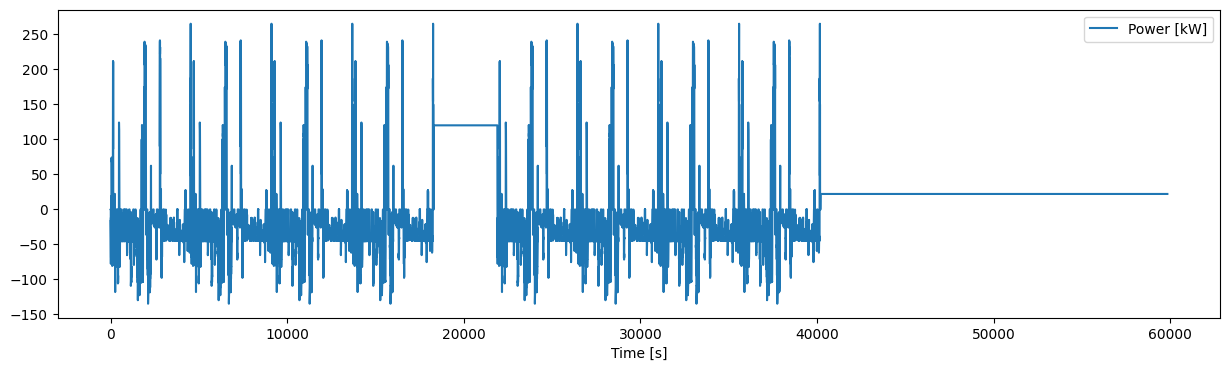

In [642]:
cycle.plot(x='Time [s]', y='Power [kW]', figsize=(15,4))

<Axes: xlabel='Time [s]'>

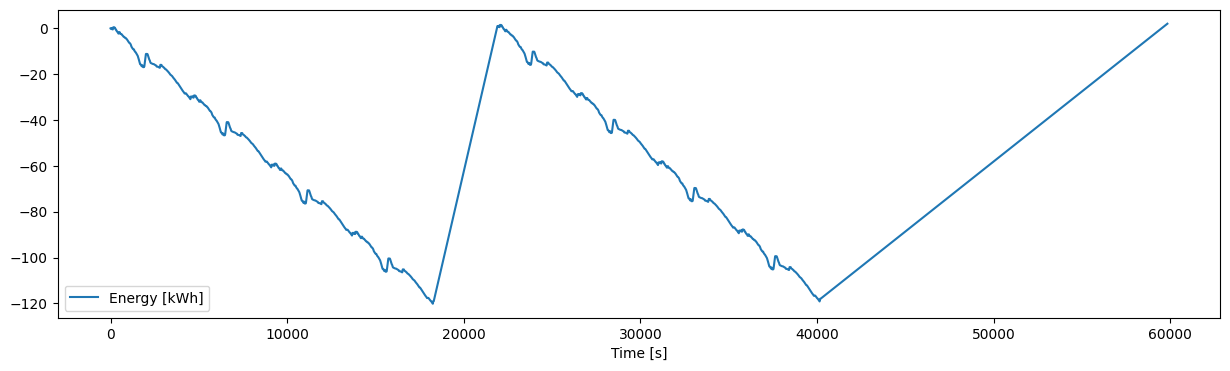

In [643]:
cycle['Energy [kWh]'] = (cycle['Power [kW]'].cumsum())/3600
cycle.plot(x='Time [s]', y='Energy [kWh]', figsize=(15,4))

# Assumed parameters calculation

In [644]:
calculatedParameters = {}

In [645]:
cycleUsableEnergyEOL = - cycle['Energy [kWh]'].min()
calculatedParameters['Cycle usable energy EOL [kWh]'] =  [cycleUsableEnergyEOL]
cycleUsableEnergyEOL

120.15619375267677

In [646]:
calculatedParameters['Max cycle usable energy EOL [kWh]'] =  [cycleUsableEnergyEOL * 1.3]

In [647]:
# stringConfiguration = ceil(requiredBatteryPackNominalVoltage/cellNominalVoltage) # wykorzystuję założoną wartość
# calculatedParameters['Configuration'] = [f'{stringConfiguration}S1P']
# stringConfiguration
calculatedParameters['Parallel configuration'] = np.nan

In [648]:
systemParametersDataFrame = pd.DataFrame(calculatedParameters, index = [0])
systemParametersDataFrame['System nominal voltage [V]'] = requiredBatteryPackNominalVoltage
systemParametersDataFrame

,Cycle usable energy EOL [kWh],Max cycle usable energy EOL [kWh],Parallel configuration,System nominal voltage [V]
0,120.156194,156.203052,NaN,650


#RMS analysis

## RMS Charge

In [649]:
cycle['Current [A]'] = cycle['Power [kW]'] / systemParametersDataFrame['System nominal voltage [V]'].iloc[0] * 1000

<Axes: xlabel='Time [s]'>

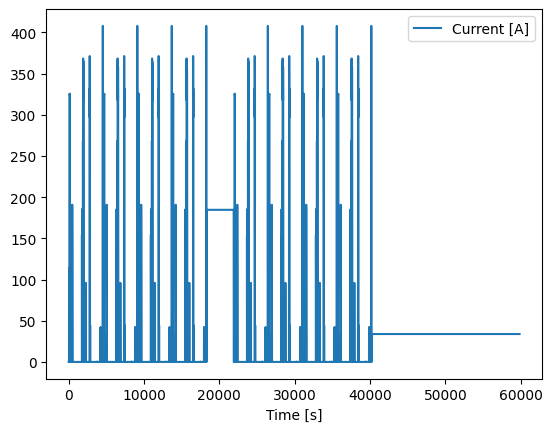

In [650]:
chargingCycle = cycle[['Time [s]', 'Current [A]']].copy()
chargingCycle['Current [A]'] = cycle['Current [A]'].where(cycle['Current [A]'] > 0).fillna(0)
chargingCycle.plot('Time [s]', 'Current [A]')

<Axes: xlabel='Time [s]'>

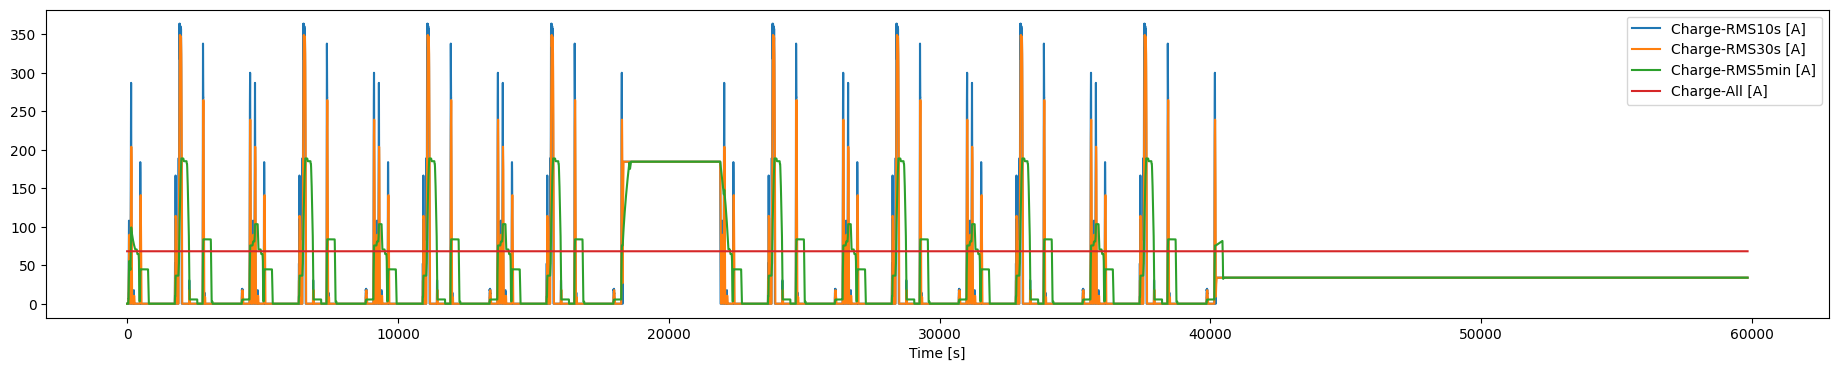

In [651]:
chargingCycle['Charge-RMS10s [A]'] = chargingCycle['Current [A]'].rolling(window=10, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
chargingCycle['Charge-RMS30s [A]'] = chargingCycle['Current [A]'].rolling(window=30, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
chargingCycle['Charge-RMS5min [A]'] = chargingCycle['Current [A]'].rolling(window=300, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
chargingCycle['Charge-All [A]'] = np.sqrt((chargingCycle['Current [A]'] ** 2).mean())
chargingCycle.plot(x='Time [s]', y=['Charge-RMS10s [A]', 'Charge-RMS30s [A]','Charge-RMS5min [A]', 'Charge-All [A]'], figsize=(23, 4))

In [652]:
maxChargingRMS = chargingCycle[['Charge-RMS10s [A]','Charge-RMS30s [A]','Charge-RMS5min [A]','Charge-All [A]']].max().to_frame().T
maxChargingRMS

,Charge-RMS10s [A],Charge-RMS30s [A],Charge-RMS5min [A],Charge-All [A]
0,363.953855,349.331891,188.815069,68.189376


In [653]:
# columns = pd.MultiIndex.from_tuples([
#     ('Charge', 'RMS10s [A]'),
#     ('Charge', 'RMS30s [A]'),
#     ('Charge', 'RMS5min [A]'),
#     ('Charge', 'All [A]')
# ])
# data = chargingCycle[['Charge-RMS10s [A]','Charge-RMS30s [A]','Charge-RMS5min [A]','Charge-All [A]']].max().to_frame().T

# maxChargingRMS = pd.DataFrame(data= data.values, columns=columns)
# maxChargingRMS

## RMS Discharge

<Axes: xlabel='Time [s]'>

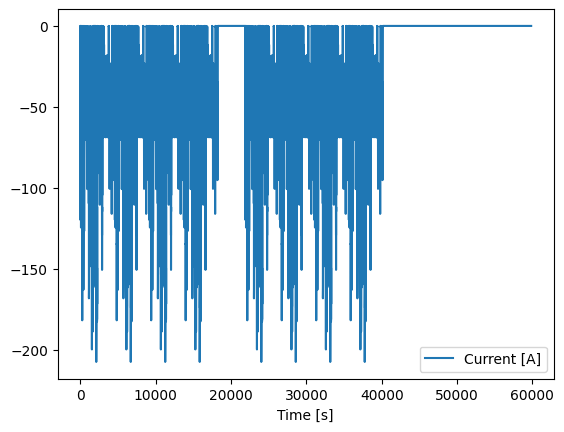

In [654]:
dischargingCycle = cycle[['Time [s]', 'Current [A]']].copy()
dischargingCycle['Current [A]'] = cycle['Current [A]'].where(cycle['Current [A]'] < 0).fillna(0)
dischargingCycle.plot('Time [s]', 'Current [A]')

<Axes: xlabel='Time [s]'>

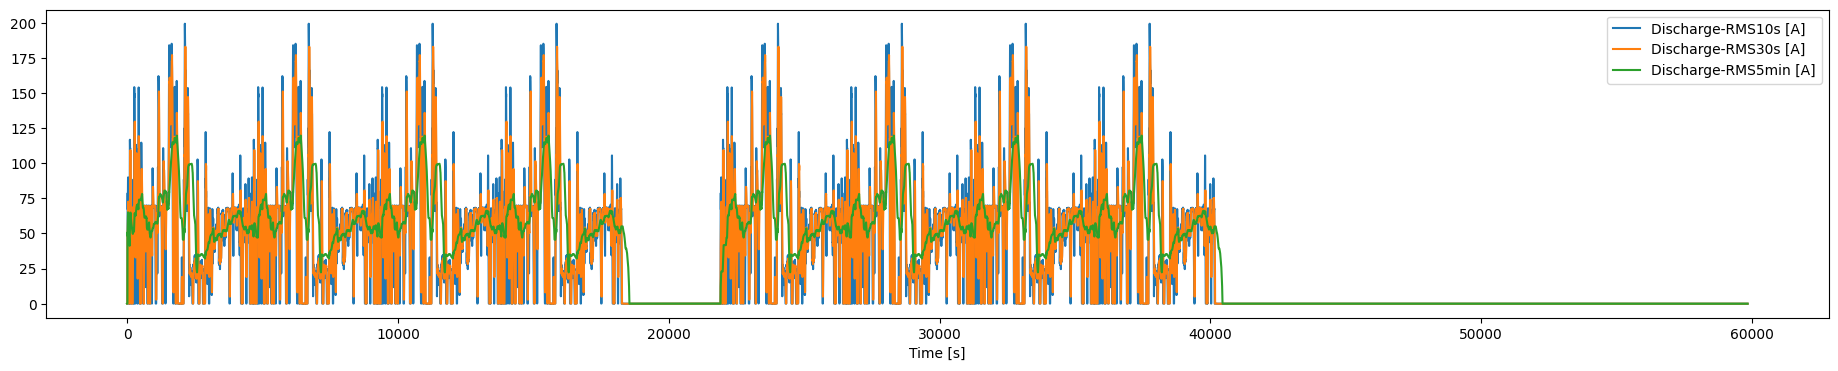

In [655]:
dischargingCycle['Discharge-RMS10s [A]'] = dischargingCycle['Current [A]'].rolling(window=10, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
dischargingCycle['Discharge-RMS30s [A]'] = dischargingCycle['Current [A]'].rolling(window=30, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
dischargingCycle['Discharge-RMS5min [A]'] = dischargingCycle['Current [A]'].rolling(window=300, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
dischargingCycle['Discharge-All [A]'] = np.sqrt((dischargingCycle['Current [A]'] ** 2).mean())
dischargingCycle.plot(x='Time [s]', y=['Discharge-RMS10s [A]', 'Discharge-RMS30s [A]','Discharge-RMS5min [A]'], figsize=(23, 4))

In [656]:
maxDischargingRMS = dischargingCycle[['Discharge-RMS10s [A]','Discharge-RMS30s [A]','Discharge-RMS5min [A]','Discharge-All [A]']].max().to_frame().T
maxDischargingRMS

,Discharge-RMS10s [A],Discharge-RMS30s [A],Discharge-RMS5min [A],Discharge-All [A]
0,199.364826,182.968746,119.700887,51.280849


In [657]:
# columns = pd.MultiIndex.from_tuples([
#     ('Discharge', 'RMS10s [A]'),
#     ('Discharge', 'RMS30s [A]'),
#     ('Discharge', 'RMS5min [A]'),
#     ('Discharge', 'All [A]')
# ])
# data = dischargingCycle[['Discharge-RMS10s [A]','Discharge-RMS30s [A]','Discharge-RMS5min [A]','Discharge-All [A]']].max().to_frame().T

# maxDischargingRMS = pd.DataFrame(data= data.values, columns=columns)
# maxDischargingRMS

#Merging data for the cell analysis

In [658]:
mergedSystemParametersDataFrame = pd.concat([systemParametersDataFrame, maxDischargingRMS, maxChargingRMS], axis='columns')
mergedSystemParametersDataFrame

,Cycle usable energy EOL [kWh],Max cycle usable energy EOL [kWh],Parallel configuration,System nominal voltage [V],Discharge-RMS10s [A],Discharge-RMS30s [A],Discharge-RMS5min [A],Discharge-All [A],Charge-RMS10s [A],Charge-RMS30s [A],Charge-RMS5min [A],Charge-All [A]
0,120.156194,156.203052,NaN,650,199.364826,182.968746,119.700887,51.280849,363.953855,349.331891,188.815069,68.189376


In [659]:
listColumnsToChange = ['Cycle usable energy EOL [kWh]', 'Max cycle usable energy EOL [kWh]',
                       'Charge-RMS10s [A]','Charge-RMS30s [A]','Charge-RMS5min [A]','Charge-All [A]',
                       'Discharge-RMS10s [A]','Discharge-RMS30s [A]','Discharge-RMS5min [A]','Discharge-All [A]'
                       ]

systemConfigurationsDataframe = pd.DataFrame(columns=mergedSystemParametersDataFrame.columns)
for parallel in range(1,9):
  newRow = mergedSystemParametersDataFrame.copy()
  newRow[listColumnsToChange] = newRow[listColumnsToChange] / parallel
  newRow['Parallel configuration'] = int(parallel)
  systemConfigurationsDataframe.loc[len(systemConfigurationsDataframe)] = newRow.values[0]

systemConfigurationsDataframe.set_index('Parallel configuration', inplace=True)
systemConfigurationsDataframe

,Cycle usable energy EOL [kWh],Max cycle usable energy EOL [kWh],System nominal voltage [V],Discharge-RMS10s [A],Discharge-RMS30s [A],Discharge-RMS5min [A],Discharge-All [A],Charge-RMS10s [A],Charge-RMS30s [A],Charge-RMS5min [A],Charge-All [A]
Parallel configuration,,,,,,,,,,,
1.0,120.156194,156.203052,650.0,199.364826,182.968746,119.700887,51.280849,363.953855,349.331891,188.815069,68.189376
2.0,60.078097,78.101526,650.0,99.682413,91.484373,59.850444,25.640424,181.976927,174.665946,94.407535,34.094688
3.0,40.052065,52.067684,650.0,66.454942,60.989582,39.900296,17.093616,121.317952,116.443964,62.938356,22.729792
4.0,30.039048,39.050763,650.0,49.841207,45.742187,29.925222,12.820212,90.988464,87.332973,47.203767,17.047344
5.0,24.031239,31.240610,650.0,39.872965,36.593749,23.940177,10.256170,72.790771,69.866378,37.763014,13.637875
6.0,20.026032,26.033842,650.0,33.227471,30.494791,19.950148,8.546808,60.658976,58.221982,31.469178,11.364896
7.0,17.165171,22.314722,650.0,28.480689,26.138392,17.100127,7.325836,51.993408,49.904556,26.973581,9.741339
8.0,15.019524,19.525381,650.0,24.920603,22.871093,14.962611,6.410106,45.494232,43.666486,23.601884,8.523672


#Choosing cells

##Prepering cell database


### Import cell Database

In [660]:
data = pd.read_excel('/content/drive/My Drive/Magister/Cell_database-01-04.xlsx')
fullCellDatabase = data.copy()
fullCellDatabase.head()

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
0,CATL-LFP-173Ah,CATL,PRISMATIC,LFP,173.0,3.22,NaN,NaN,173.0,173.0,519.0,346.0,NaN,0.8,3000,41.0,205.0,174.0,3.20,1.0
1,CATL-LFP-228Ah,CATL,PRISMATIC,LFP,228.0,3.22,NaN,NaN,228.0,228.0,684.0,456.0,NaN,0.8,3000,53.7,205.0,174.0,4.17,1.0
2,CATL-LFP-302Ah,CATL,PRISMATIC,LFP,302.0,3.22,NaN,NaN,302.0,302.0,604.0,906.0,NaN,0.8,3000,71.6,205.0,174.0,5.50,1.0
3,CATL-LFP-119Ah,CATL,PRISMATIC,LFP,119.0,3.22,NaN,NaN,120.0,120.0,600.0,350.0,NaN,0.7,6000,34.0,201.0,172.7,2.37,1.0
4,CATL-LFP-142Ah,CATL,PRISMATIC,LFP,142.0,3.22,NaN,NaN,142.0,142.0,426.0,284.0,NaN,0.7,6000,70.0,150.0,117.0,2.60,NaN


### Delete if miss NMC or LFP

In [661]:
if missNMCFlag:
  fullCellDatabase.drop(fullCellDatabase[fullCellDatabase['Chemistry'] == 'NMC'].index, inplace=True)
  print('Deleted all NMC')
elif missLFPFlag:
  fullCellDatabase.drop(fullCellDatabase[fullCellDatabase['Chemistry'] == 'LFP'].index, inplace=True)
  print('Deleted all LFP')

### Delete if no name or no capacity value

In [662]:
#Before deleting
fullCellDatabase[(fullCellDatabase['Name']).isna() | (fullCellDatabase['Capacity [Ah]'].isna()) | (fullCellDatabase['Manufacturer'].isna()) | (fullCellDatabase['Cycles'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]


In [663]:
#after deleting
fullCellDatabase.dropna(subset=['Name', 'Capacity [Ah]', 'Manufacturer', 'Cycles'], inplace=True)
fullCellDatabase[(fullCellDatabase['Name']).isna() | (fullCellDatabase['Capacity [Ah]'].isna()) | (fullCellDatabase['Manufacturer'].isna()) | (fullCellDatabase['Cycles'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]


### Delete if no dimension or mass

In [664]:
#Before deleting
fullCellDatabase[(fullCellDatabase['Mass [kg]']).isna() | (fullCellDatabase['Width [mm]'].isna()) | (fullCellDatabase['Length [mm]'].isna()) | (fullCellDatabase['Height [mm]'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]


In [665]:
#after deleting
fullCellDatabase.dropna(subset=['Mass [kg]', 'Width [mm]', 'Length [mm]', 'Height [mm]'], inplace=True)
fullCellDatabase[(fullCellDatabase['Mass [kg]']).isna() | (fullCellDatabase['Width [mm]'].isna()) | (fullCellDatabase['Length [mm]'].isna()) | (fullCellDatabase['Height [mm]'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]


### Change duplicated names

In [666]:
fullCellDatabase[fullCellDatabase['Name'].duplicated()].head()

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
17,SVOLT-LFP-90Ah,SVOLT,BLADE,LFP,90.0,3.13,2.0,3.65,NaN,NaN,NaN,NaN,NaN,NaN,2500,14.6,409.0,88.0,1.20,NaN
21,SVOLT-LFP-184Ah,SVOLT,BLADE,LFP,184.0,3.20,2.0,3.65,NaN,NaN,NaN,NaN,0.97,NaN,2500,21.5,574.0,118.0,3.40,NaN
27,SVOLT-NMC-114Ah,SVOLT,PRISMATIC,NMC,114.0,3.74,2.8,4.35,NaN,NaN,NaN,NaN,0.90,NaN,2000,52.0,148.0,102.5,1.85,NaN
33,SVOLT-NMC-115Ah,SVOLT,PRISMATIC,NMC,115.0,3.74,2.8,4.30,NaN,NaN,NaN,NaN,0.90,NaN,2500,32.7,220.0,106.2,1.80,NaN
41,CATL-LFP-119Ah,CATL,PRISMATIC,LFP,119.0,3.20,NaN,NaN,132.0,132.0,250.0,250.0,NaN,0.8,6000,33.0,200.0,172.0,2.40,NaN


In [667]:
n = 2
while not fullCellDatabase['Name'].is_unique:
  fullCellDatabase.loc[fullCellDatabase['Name'].duplicated(), 'Name'] += f' - {n}'
  n+=1
fullCellDatabase['Name'].is_unique

True

### Change voltage NaN

In [668]:
fullCellDatabase.columns
NMCBasedata = {
    'Chemistry': 'NMC',
    'Nominal voltage [V]': 3.6,
    'Min operating voltage [V]': 2.8,
    'Max operating voltage [V]': 4.2,
    'DoD' : 0.8,
    'SOH EOL': 0.7
}
LFPBasedata = {
    'Chemistry': 'LFP',
    'Nominal voltage [V]': 3.2,
    'Min operating voltage [V]': 2.5,
    'Max operating voltage [V]': 3.6,
    'DoD' : 0.95,
    'SOH EOL': 0.7
}
dataToReplace = pd.DataFrame(data=[NMCBasedata, LFPBasedata]).set_index('Chemistry')
dataToReplace

,Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],DoD,SOH EOL
Chemistry,,,,,
NMC,3.6,2.8,4.2,0.80,0.7
LFP,3.2,2.5,3.6,0.95,0.7


In [669]:
fullCellDatabase[(fullCellDatabase['Chemistry'] == 'NMC') & (fullCellDatabase['Nominal voltage [V]'].isna())]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]


In [670]:
fullCellDatabase[dataToReplace.columns].isna().any()

,0
Nominal voltage [V],True
Min operating voltage [V],True
Max operating voltage [V],True
DoD,True
SOH EOL,True


In [671]:
#Uzupełnienie napięć, DoD i SOH
for index in dataToReplace.index:
  for column in dataToReplace.columns:
    fullCellDatabase.loc[(fullCellDatabase['Chemistry'] == index) & (fullCellDatabase[column].isna()), column] = dataToReplace.loc[index, column]

In [672]:
fullCellDatabase[dataToReplace.columns].isna().any()

,0
Nominal voltage [V],False
Min operating voltage [V],False
Max operating voltage [V],False
DoD,False
SOH EOL,False


### Fill space nan

In [673]:
fullCellDatabase['Space between cells [mm]'].fillna(value=1, inplace=True)
fullCellDatabase['Space between cells [mm]']

<ipython-input-673-e2f0a2951d55>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fullCellDatabase['Space between cells [mm]'].fillna(value=1, inplace=True)


,Space between cells [mm]
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
64,1.0
65,1.0
66,1.0
67,1.0


### Fill charge/discharge currents NaN

In [674]:
# jest to mocne przybliżenie, jednak przy braku danych najlepsze. Założeniem jest dokładność używanej bazy danych

cRateDatabase = {
    'Constant discharge current [A]': 1,
    'Constant charge current [A]': 1,
    'RMS Discharge 30s [A]': 2.5,
    'RMS Charge 30s [A]': 2
}
cRateToReplaceCurrent = pd.DataFrame(data=[cRateDatabase])

In [675]:
indextoCheck = fullCellDatabase.loc[(fullCellDatabase['Constant discharge current [A]'].isna())].head(3).index
fullCellDatabase.iloc[indextoCheck]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
16,SVOLT-LFP-62Ah,SVOLT,BLADE,LFP,62.0,3.13,2.0,3.65,NaN,NaN,NaN,NaN,0.97,0.7,2500,14.6,409.0,88.0,1.2,1.0
17,SVOLT-LFP-90Ah - 2,SVOLT,BLADE,LFP,90.0,3.13,2.0,3.65,NaN,NaN,NaN,NaN,0.95,0.7,2500,14.6,409.0,88.0,1.2,1.0
18,SVOLT-LFP-106Ah,SVOLT,PRISMATIC,LFP,106.0,3.20,2.0,3.65,NaN,NaN,NaN,NaN,0.97,0.7,2500,52.0,148.0,112.0,1.9,1.0


In [676]:
for column in cRateToReplaceCurrent.columns:
  fullCellDatabase.loc[(fullCellDatabase[column].isna()), column] = cRateToReplaceCurrent.loc[0, column] * fullCellDatabase['Capacity [Ah]']
fullCellDatabase.iloc[indextoCheck]

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm]
16,SVOLT-LFP-62Ah,SVOLT,BLADE,LFP,62.0,3.13,2.0,3.65,62.0,62.0,155.0,124.0,0.97,0.7,2500,14.6,409.0,88.0,1.2,1.0
17,SVOLT-LFP-90Ah - 2,SVOLT,BLADE,LFP,90.0,3.13,2.0,3.65,90.0,90.0,225.0,180.0,0.95,0.7,2500,14.6,409.0,88.0,1.2,1.0
18,SVOLT-LFP-106Ah,SVOLT,PRISMATIC,LFP,106.0,3.20,2.0,3.65,106.0,106.0,265.0,212.0,0.97,0.7,2500,52.0,148.0,112.0,1.9,1.0


In [677]:
columnsToCheck = ['Name', 'Manufacturer', 'Cell type', 'Chemistry',
                  'Capacity [Ah]', 'Nominal voltage [V]',
                  'Min operating voltage [V]', 'Max operating voltage [V]',
                  'Constant discharge current [A]', 'Constant charge current [A]',
                  'RMS Discharge 30s [A]', 'RMS Charge 30s [A]', 'DoD',
                  'SOH EOL', 'Cycles']
if fullCellDatabase[columnsToCheck].isna().any().any():  # Jeśli chociaż jedno NaN
    missing_cols = fullCellDatabase.isna().any()  # Seria True dla wierszy z NaN
    missing_indices = fullCellDatabase.columns[missing_cols].tolist()  # Lista indeksów
    raise ValueError(f"Some data are missing. Check columns: {missing_indices}")

###Sort dimesions - longitudinal/width/heigh

In [678]:
# fullCellDatabase.iloc[[54, 58, 59]]

In [679]:
#sorting to make length always bigger than width
mask = fullCellDatabase["Width [mm]"] > fullCellDatabase["Length [mm]"]

fullCellDatabase.loc[mask, ["Width [mm]", "Length [mm]"]] = (
    fullCellDatabase.loc[mask, ["Length [mm]", "Width [mm]"]].values
)
# fullCellDatabase.iloc[[54, 58, 59]]

###Add Price

In [680]:
def Price(x):
  if x == 'LFP':
    return 59
  elif x == 'NMC':
    return 68.5
  else:
    raise ValueError(f'Value {x} is unknown')


fullCellDatabase['Price for the chemistry [$/kWh]'] = fullCellDatabase['Chemistry'].apply(Price)
fullCellDatabase.head()

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],...,RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm],Price for the chemistry [$/kWh]
0,CATL-LFP-173Ah,CATL,PRISMATIC,LFP,173.0,3.22,2.5,3.6,173.0,173.0,...,346.0,0.95,0.8,3000,41.0,205.0,174.0,3.20,1.0,59.0
1,CATL-LFP-228Ah,CATL,PRISMATIC,LFP,228.0,3.22,2.5,3.6,228.0,228.0,...,456.0,0.95,0.8,3000,53.7,205.0,174.0,4.17,1.0,59.0
2,CATL-LFP-302Ah,CATL,PRISMATIC,LFP,302.0,3.22,2.5,3.6,302.0,302.0,...,906.0,0.95,0.8,3000,71.6,205.0,174.0,5.50,1.0,59.0
3,CATL-LFP-119Ah,CATL,PRISMATIC,LFP,119.0,3.22,2.5,3.6,120.0,120.0,...,350.0,0.95,0.7,6000,34.0,201.0,172.7,2.37,1.0,59.0
4,CATL-LFP-142Ah,CATL,PRISMATIC,LFP,142.0,3.22,2.5,3.6,142.0,142.0,...,284.0,0.95,0.7,6000,70.0,150.0,117.0,2.60,1.0,59.0


### show filled database

In [681]:
# fullCellDatabase.columns

In [682]:
fullCellDatabase.iloc[30]

,30
Name,"SVOLT-NMC-136,5Ah"
Manufacturer,SVOLT
Cell type,PRISMATIC
Chemistry,NMC
Capacity [Ah],136.5
Nominal voltage [V],3.6
Min operating voltage [V],2.5
Max operating voltage [V],4.2
Constant discharge current [A],136.5
Constant charge current [A],136.5


## Initial cells analysis

In [683]:
columnsToAnalysis = ['Name', 'Chemistry', 'Capacity [Ah]', 'Nominal voltage [V]',
                     'Constant discharge current [A]', 'RMS Discharge 30s [A]',
                     'Constant charge current [A]', 'RMS Charge 30s [A]',
                     'DoD', 'SOH EOL', 'Cycles'
                     ]
cellDatabase = fullCellDatabase[columnsToAnalysis].copy()
cellDatabase.head(10)

,Name,Chemistry,Capacity [Ah],Nominal voltage [V],Constant discharge current [A],RMS Discharge 30s [A],Constant charge current [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles
0,CATL-LFP-173Ah,LFP,173.0,3.22,173.0,519.0,173.0,346.0,0.95,0.8,3000
1,CATL-LFP-228Ah,LFP,228.0,3.22,228.0,684.0,228.0,456.0,0.95,0.8,3000
2,CATL-LFP-302Ah,LFP,302.0,3.22,302.0,604.0,302.0,906.0,0.95,0.8,3000
3,CATL-LFP-119Ah,LFP,119.0,3.22,120.0,600.0,120.0,350.0,0.95,0.7,6000
4,CATL-LFP-142Ah,LFP,142.0,3.22,142.0,426.0,142.0,284.0,0.95,0.7,6000
5,SVOLT-LFP-90Ah,LFP,90.0,3.22,250.0,350.0,180.0,180.0,0.90,0.8,3000
6,SVOLT-NMC-90Ah,NMC,90.0,3.60,180.0,380.0,90.0,180.0,0.94,0.8,2000
7,GOTION-LFP-340Ah,LFP,340.0,3.20,340.0,680.0,340.0,408.0,0.90,0.8,2000
8,GOTION-LFP-300Ah,LFP,300.0,3.20,300.0,600.0,210.0,420.0,0.90,0.8,6000
9,GOTION-LFP-105Ah,LFP,105.0,3.20,105.0,300.0,105.0,150.0,0.90,0.8,3000


In [684]:
def AddStringConfiguration(x):
  if x == 'LFP':
    return 204
  elif x == 'NMC':
    return 180
  else:
    return np.ceil(systemConfigurationsDataframe['System nominal voltage [V]'].iloc[0] / cellDatabase['Nominal voltage [V]'])


cellDatabase['Cell string configuration for the system'] = cellDatabase['Chemistry'].apply(AddStringConfiguration)
cellDatabase.head()

,Name,Chemistry,Capacity [Ah],Nominal voltage [V],Constant discharge current [A],RMS Discharge 30s [A],Constant charge current [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Cell string configuration for the system
0,CATL-LFP-173Ah,LFP,173.0,3.22,173.0,519.0,173.0,346.0,0.95,0.8,3000,204
1,CATL-LFP-228Ah,LFP,228.0,3.22,228.0,684.0,228.0,456.0,0.95,0.8,3000,204
2,CATL-LFP-302Ah,LFP,302.0,3.22,302.0,604.0,302.0,906.0,0.95,0.8,3000,204
3,CATL-LFP-119Ah,LFP,119.0,3.22,120.0,600.0,120.0,350.0,0.95,0.7,6000,204
4,CATL-LFP-142Ah,LFP,142.0,3.22,142.0,426.0,142.0,284.0,0.95,0.7,6000,204


In [685]:
cellDatabase['Usable batterypack energy EOL [kWh]'] = cellDatabase['Capacity [Ah]'] * cellDatabase['SOH EOL'] * cellDatabase['DoD'] * systemConfigurationsDataframe['System nominal voltage [V]'].iloc[0]/ 1000
cellDatabase['Max usable batterypack energy EOL [kWh]'] = cellDatabase['Usable batterypack energy EOL [kWh]'] * 1.2
cellDatabase.head()

,Name,Chemistry,Capacity [Ah],Nominal voltage [V],Constant discharge current [A],RMS Discharge 30s [A],Constant charge current [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles,Cell string configuration for the system,Usable batterypack energy EOL [kWh],Max usable batterypack energy EOL [kWh]
0,CATL-LFP-173Ah,LFP,173.0,3.22,173.0,519.0,173.0,346.0,0.95,0.8,3000,204,85.46200,102.5544
1,CATL-LFP-228Ah,LFP,228.0,3.22,228.0,684.0,228.0,456.0,0.95,0.8,3000,204,112.63200,135.1584
2,CATL-LFP-302Ah,LFP,302.0,3.22,302.0,604.0,302.0,906.0,0.95,0.8,3000,204,149.18800,179.0256
3,CATL-LFP-119Ah,LFP,119.0,3.22,120.0,600.0,120.0,350.0,0.95,0.7,6000,204,51.43775,61.7253
4,CATL-LFP-142Ah,LFP,142.0,3.22,142.0,426.0,142.0,284.0,0.95,0.7,6000,204,61.37950,73.6554


In [686]:
136.5*650*0.8*0.9/1000

63.882

In [687]:
cellDatabase.iloc[30]

,30
Name,"SVOLT-NMC-136,5Ah"
Chemistry,NMC
Capacity [Ah],136.5
Nominal voltage [V],3.6
Constant discharge current [A],136.5
RMS Discharge 30s [A],341.25
Constant charge current [A],136.5
RMS Charge 30s [A],273.0
DoD,0.9
SOH EOL,0.8


In [688]:
# Wybierz z cellDatabase tylko te ogniwa, które mają w takim systemie większą
# zgromadzoną energię użyteczną EOL niż wymagana, oraz maksymalną energię
# użyteczną EOL (1.2 energii obliczonej z ogniw) mniejszą, niż maksymalna
# wymagana (1.3 użytecznej energii z cyklu)

sufficientCells = pd.DataFrame()

for index in systemConfigurationsDataframe.index:
    newSufficientCells = cellDatabase[
        (cellDatabase['Usable batterypack energy EOL [kWh]'] > systemConfigurationsDataframe.loc[index, 'Cycle usable energy EOL [kWh]']) &
        (cellDatabase['Max usable batterypack energy EOL [kWh]'] < systemConfigurationsDataframe.loc[index, 'Max cycle usable energy EOL [kWh]'])
    ].copy()
    newSufficientCells['Parallel configuration'] = int(index) # musi być tak żeby zrobić multiindex
    sufficientCells = pd.concat([sufficientCells, newSufficientCells], ignore_index=True)

sufficientCells.set_index(['Parallel configuration', 'Name'], inplace=True)
sufficientCells.head()

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                         
2                      CATL-LFP-142Ah          LFP          142.0   
                       SVOLT-LFP-147Ah         LFP          147.0   
                       SVOLT-NMC-136,5Ah       NMC          136.5   
                       SVOLT-NMC-149Ah         NMC          149.0   
                       REPT-LFP-130Ah          LFP          130.0   

                                          Nominal voltage [V]  \
Parallel configuration Name                                     
2                      CATL-LFP-142Ah                    3.22   
                       SVOLT-LFP-147Ah                   3.20   
                       SVOLT-NMC-136,5Ah                 3.60   
                       SVOLT-NMC-149Ah                   3.80   
                       REPT-LFP-130Ah                    3.20   

                                          Constant discharge current [A]  \
Parallel configuration Name                                                
2                      CATL-LFP-142Ah                              142.0   
                       SVOLT-LFP-147Ah                             147.0   
                       SVOLT-NMC-136,5Ah                           136.5   
                       SVOLT-NMC-149Ah                             149.0   
                       REPT-LFP-130Ah                              130.0   

                                          RMS Discharge 30s [A]  \
Parallel configuration Name                                       
2                      CATL-LFP-142Ah                    426.00   
                       SVOLT-LFP-147Ah                   367.50   
                       SVOLT-NMC-136,5Ah                 341.25   
                       SVOLT-NMC-149Ah                   372.50   
                       REPT-LFP-130Ah                    250.00   

                                          Constant charge current [A]  \
Parallel configuration Name                                             
2                      CATL-LFP-142Ah                           142.0   
                       SVOLT-LFP-147Ah                          147.0   
                       SVOLT-NMC-136,5Ah                        136.5   
                       SVOLT-NMC-149Ah                          149.0   
                       REPT-LFP-130Ah                           130.0   

                                          RMS Charge 30s [A]   DoD  SOH EOL  \
Parallel configuration Name                                                   
2                      CATL-LFP-142Ah                  284.0  0.95      0.7   
                       SVOLT-LFP-147Ah                 294.0  0.97      0.7   
                       SVOLT-NMC-136,5Ah               273.0  0.90      0.8   
                       SVOLT-NMC-149Ah                 298.0  0.90      0.7   
                       REPT-LFP-130Ah                  200.0  0.95      0.8   

                                          Cycles  \
Parallel configuration Name                        
2                      CATL-LFP-142Ah       6000   
                       SVOLT-LFP-147Ah      2500   
                       SVOLT-NMC-136,5Ah    1400   
                       SVOLT-NMC-149Ah      1200   
                       REPT-LFP-130Ah       2000   

                                          Cell string configuration for the system  \
Parallel configuration Name                                                          
2                      CATL-LFP-142Ah                                          204   
                       SVOLT-LFP-147Ah                                         204   
                       SVOLT-NMC-136,5Ah                                       180   
                       SVOLT-NMC-149Ah                                         180   
                       REPT-LFP-130Ah                                          204   

                                          Usable batterypack ene

In [689]:
sufficientCells.iloc[1]

,2
,SVOLT-LFP-147Ah
Chemistry,LFP
Capacity [Ah],147.0
Nominal voltage [V],3.2
Constant discharge current [A],147.0
RMS Discharge 30s [A],367.5
Constant charge current [A],147.0
RMS Charge 30s [A],294.0
DoD,0.97
SOH EOL,0.7


## RMS Cells analysis

In [690]:
sufficientCells['Installed batterypack energy BOL [kWh]'] = sufficientCells['Nominal voltage [V]'] * sufficientCells['Cell string configuration for the system'] * sufficientCells['Capacity [Ah]'] / 1000
sufficientCells.head()

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                         
2                      CATL-LFP-142Ah          LFP          142.0   
                       SVOLT-LFP-147Ah         LFP          147.0   
                       SVOLT-NMC-136,5Ah       NMC          136.5   
                       SVOLT-NMC-149Ah         NMC          149.0   
                       REPT-LFP-130Ah          LFP          130.0   

                                          Nominal voltage [V]  \
Parallel configuration Name                                     
2                      CATL-LFP-142Ah                    3.22   
                       SVOLT-LFP-147Ah                   3.20   
                       SVOLT-NMC-136,5Ah                 3.60   
                       SVOLT-NMC-149Ah                   3.80   
                       REPT-LFP-130Ah                    3.20   

                                          Constant discharge current [A]  \
Parallel configuration Name                                                
2                      CATL-LFP-142Ah                              142.0   
                       SVOLT-LFP-147Ah                             147.0   
                       SVOLT-NMC-136,5Ah                           136.5   
                       SVOLT-NMC-149Ah                             149.0   
                       REPT-LFP-130Ah                              130.0   

                                          RMS Discharge 30s [A]  \
Parallel configuration Name                                       
2                      CATL-LFP-142Ah                    426.00   
                       SVOLT-LFP-147Ah                   367.50   
                       SVOLT-NMC-136,5Ah                 341.25   
                       SVOLT-NMC-149Ah                   372.50   
                       REPT-LFP-130Ah                    250.00   

                                          Constant charge current [A]  \
Parallel configuration Name                                             
2                      CATL-LFP-142Ah                           142.0   
                       SVOLT-LFP-147Ah                          147.0   
                       SVOLT-NMC-136,5Ah                        136.5   
                       SVOLT-NMC-149Ah                          149.0   
                       REPT-LFP-130Ah                           130.0   

                                          RMS Charge 30s [A]   DoD  SOH EOL  \
Parallel configuration Name                                                   
2                      CATL-LFP-142Ah                  284.0  0.95      0.7   
                       SVOLT-LFP-147Ah                 294.0  0.97      0.7   
                       SVOLT-NMC-136,5Ah               273.0  0.90      0.8   
                       SVOLT-NMC-149Ah                 298.0  0.90      0.7   
                       REPT-LFP-130Ah                  200.0  0.95      0.8   

                                          Cycles  \
Parallel configuration Name                        
2                      CATL-LFP-142Ah       6000   
                       SVOLT-LFP-147Ah      2500   
                       SVOLT-NMC-136,5Ah    1400   
                       SVOLT-NMC-149Ah      1200   
                       REPT-LFP-130Ah       2000   

                                          Cell string configuration for the system  \
Parallel configuration Name                                                          
2                      CATL-LFP-142Ah                                          204   
                       SVOLT-LFP-147Ah                                         204   
                       SVOLT-NMC-136,5Ah                                       180   
                       SVOLT-NMC-149Ah                                         180   
                       REPT-LFP-130Ah                                          204   

                                          Usable batterypack ene

In [691]:
sufficientCells[['Constant charge current [A]', 'RMS Discharge 30s [A]','Constant discharge current [A]', 'RMS Charge 30s [A]']]

Constant charge current [A]  \
Parallel configuration Name                                              
2                      CATL-LFP-142Ah                            142.0   
                       SVOLT-LFP-147Ah                           147.0   
                       SVOLT-NMC-136,5Ah                         136.5   
                       SVOLT-NMC-149Ah                           149.0   
                       REPT-LFP-130Ah                            130.0   
                       REPT-LFP-130Ah - 2                        130.0   
                       EVE-LFP-125Ah                             125.0   
                       REPT-NMC-177Ah                            177.0   
3                      SVOLT-LFP-90Ah                            180.0   
5                      EVE-LFP-50Ah                               25.0   
                       EVE-LFP-50Ah - 2                           50.0   
6                      GOTION-NMC-50Ah                            60.0   
7                      GOTION-LFP-40Ah                            40.0   
                       SVOLT-NMC-51Ah                             51.0   
8                      EVE-LFP-32Ah                               16.0   

                                           RMS Discharge 30s [A]  \
Parallel configuration Name                                        
2                      CATL-LFP-142Ah                     426.00   
                       SVOLT-LFP-147Ah                    367.50   
                       SVOLT-NMC-136,5Ah                  341.25   
                       SVOLT-NMC-149Ah                    372.50   
                       REPT-LFP-130Ah                     250.00   
                       REPT-LFP-130Ah - 2                 208.00   
                       EVE-LFP-125Ah                      312.50   
                       REPT-NMC-177Ah                     400.00   
3                      SVOLT-LFP-90Ah                     350.00   
5                      EVE-LFP-50Ah                       150.00   
                       EVE-LFP-50Ah - 2                   150.00   
6                      GOTION-NMC-50Ah                    250.00   
7                      GOTION-LFP-40Ah                    400.00   
                       SVOLT-NMC-51Ah                     127.50   
8                      EVE-LFP-32Ah                        32.00   

                                           Constant discharge current [A]  \
Parallel configuration Name                                                 
2                      CATL-LFP-142Ah                               142.0   
                       SVOLT-LFP-147Ah                              147.0   
                       SVOLT-NMC-136,5Ah                            136.5   
                       SVOLT-NMC-149Ah                              149.0   
                       REPT-LFP-130Ah                               130.0   
                       REPT-LFP-130Ah - 2                           130.0   
                       EVE-LFP-125Ah                                125.0   
                       REPT-NMC-177Ah                               200.0   
3                      SVOLT-LFP-90Ah                               250.0   
5                      EVE-LFP-50Ah                                  25.0   
                       EVE-LFP-50Ah - 2                              50.0   
6                      GOTION-NMC-50Ah                               80.0   
7                      GOTION-LFP-40Ah                               40.0   
                       SVOLT-NMC-51Ah                                51.0   
8                      EVE-LFP-32Ah                                  16.0   

                                           RMS Charge 30s [A]  
Parallel configuration Name                                    
2                      CATL-LFP-142Ah                   284.0  
                       SVOLT-LFP-147Ah                  294.0  
                       SVOLT-NMC-136,5Ah                273.0

In [692]:
systemConfigurationsDataframe['Charge-All [A]']

,Charge-All [A]
Parallel configuration,
1.0,68.189376
2.0,34.094688
3.0,22.729792
4.0,17.047344
5.0,13.637875
6.0,11.364896
7.0,9.741339
8.0,8.523672


In [693]:
# ------------------------ RMS całkowity ---------------------------
rowsToStay = []

for index in sufficientCells.index.get_level_values(0).unique():
    mask = (sufficientCells['Constant charge current [A]'].loc[index] >= systemConfigurationsDataframe['Charge-All [A]'].loc[index]) & (sufficientCells['Constant discharge current [A]'].loc[index] >= systemConfigurationsDataframe['Discharge-All [A]'].loc[index])

    newRow = mask.reset_index()
    newRow['Parallel configuration'] = index
    newRow.set_index(['Parallel configuration', 'Name'], inplace=True)
    rowsToStay.append(newRow)

rowsToStay = pd.concat(rowsToStay).sort_index()

sufficientCells = sufficientCells[rowsToStay[0].values]

sufficientCells
#--------------------- inny sposób ---------------------------
# rowsToStay = pd.DataFrame()

# for index in sufficientCells.index.get_level_values(0).unique():
#   chargingCellCheck = sufficientCells['Constant charge current [A]'].loc[index] >= systemConfigurationsDataframe['Charge-All [A]'].loc[index]
#   dischargingCellCheck = sufficientCells['Constant discharge current [A]'].loc[index] >= systemConfigurationsDataframe['Discharge-All [A]'].loc[index]
#   newRow = chargingCellCheck & dischargingCellCheck
#   newRow = newRow.reset_index()
#   newRow['Parallel configuration'] = index
#   newRow.set_index(['Parallel configuration','Name'], inplace=True)
#   rowsToStay = pd.concat([newRow, rowsToStay])

# rowsToStay.sort_index(inplace=True)
# sufficientCells = sufficientCells[rowsToStay.values]
# sufficientCells.head(10)

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                          
2                      CATL-LFP-142Ah           LFP          142.0   
                       SVOLT-LFP-147Ah          LFP          147.0   
                       SVOLT-NMC-136,5Ah        NMC          136.5   
                       SVOLT-NMC-149Ah          NMC          149.0   
                       REPT-LFP-130Ah           LFP          130.0   
                       REPT-LFP-130Ah - 2       LFP          130.0   
                       EVE-LFP-125Ah            LFP          125.0   
                       REPT-NMC-177Ah           NMC          177.0   
3                      SVOLT-LFP-90Ah           LFP           90.0   
5                      EVE-LFP-50Ah             LFP           50.0   
                       EVE-LFP-50Ah - 2         LFP           50.0   
6                      GOTION-NMC-50Ah          NMC           50.0   
7                      GOTION-LFP-40Ah          LFP           40.0   
                       SVOLT-NMC-51Ah           NMC           51.0   
8                      EVE-LFP-32Ah             LFP           32.0   

                                           Nominal voltage [V]  \
Parallel configuration Name                                      
2                      CATL-LFP-142Ah                     3.22   
                       SVOLT-LFP-147Ah                    3.20   
                       SVOLT-NMC-136,5Ah                  3.60   
                       SVOLT-NMC-149Ah                    3.80   
                       REPT-LFP-130Ah                     3.20   
                       REPT-LFP-130Ah - 2                 3.20   
                       EVE-LFP-125Ah                      3.20   
                       REPT-NMC-177Ah                     3.75   
3                      SVOLT-LFP-90Ah                     3.22   
5                      EVE-LFP-50Ah                       3.20   
                       EVE-LFP-50Ah - 2                   3.20   
6                      GOTION-NMC-50Ah                    3.60   
7                      GOTION-LFP-40Ah                    3.20   
                       SVOLT-NMC-51Ah                     3.62   
8                      EVE-LFP-32Ah                       3.20   

                                           Constant discharge current [A]  \
Parallel configuration Name                                                 
2                      CATL-LFP-142Ah                               142.0   
                       SVOLT-LFP-147Ah                              147.0   
                       SVOLT-NMC-136,5Ah                            136.5   
                       SVOLT-NMC-149Ah                              149.0   
                       REPT-LFP-130Ah                               130.0   
                       REPT-LFP-130Ah - 2                           130.0   
                       EVE-LFP-125Ah                                125.0   
                       REPT-NMC-177Ah                               200.0   
3                      SVOLT-LFP-90Ah                               250.0   
5                      EVE-LFP-50Ah                                  25.0   
                       EVE-LFP-50Ah - 2                              50.0   
6                      GOTION-NMC-50Ah                               80.0   
7                      GOTION-LFP-40Ah                               40.0   
                       SVOLT-NMC-51Ah                                51.0   
8                      EVE-LFP-32Ah                                  16.0   

                                           RMS Discharge 30s [A]  \
Parallel configuration Name                                        
2                      CATL-LFP-142Ah                     426.00   
                       SVOLT-LFP-147Ah                    367.50   
                       SVOLT-NMC-136,5Ah                  341.25   
                       SVOLT-NMC-149Ah                    372.50   
          

In [694]:
systemConfigurationsDataframe['Charge-RMS10s [A]'].head()

,Charge-RMS10s [A]
Parallel configuration,
1.0,363.953855
2.0,181.976927
3.0,121.317952
4.0,90.988464
5.0,72.790771


In [695]:
# ------------------------------ RMS 10s ----------------------------
# trzeba będzie dodać do cell database RMS10s lub RMS30s do porównania
rowsToStay = []

for index in sufficientCells.index.get_level_values(0).unique():
    mask = (sufficientCells['RMS Charge 30s [A]'].loc[index] >= systemConfigurationsDataframe['Charge-RMS30s [A]'].loc[index]) & (sufficientCells['RMS Discharge 30s [A]'].loc[index] >= systemConfigurationsDataframe['Discharge-RMS30s [A]'].loc[index])
    newRow = mask.reset_index()
    newRow['Parallel configuration'] = index
    newRow.set_index(['Parallel configuration', 'Name'], inplace=True)
    rowsToStay.append(newRow)

rowsToStay = pd.concat(rowsToStay).sort_index()

sufficientCells = sufficientCells[rowsToStay[0].values]

# Cells analysis results

In [696]:
sufficientCells

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                          
2                      CATL-LFP-142Ah           LFP          142.0   
                       SVOLT-LFP-147Ah          LFP          147.0   
                       SVOLT-NMC-136,5Ah        NMC          136.5   
                       SVOLT-NMC-149Ah          NMC          149.0   
                       REPT-LFP-130Ah           LFP          130.0   
                       REPT-LFP-130Ah - 2       LFP          130.0   
                       EVE-LFP-125Ah            LFP          125.0   
                       REPT-NMC-177Ah           NMC          177.0   
3                      SVOLT-LFP-90Ah           LFP           90.0   
5                      EVE-LFP-50Ah             LFP           50.0   
                       EVE-LFP-50Ah - 2         LFP           50.0   
6                      GOTION-NMC-50Ah          NMC           50.0   
7                      GOTION-LFP-40Ah          LFP           40.0   
                       SVOLT-NMC-51Ah           NMC           51.0   

                                           Nominal voltage [V]  \
Parallel configuration Name                                      
2                      CATL-LFP-142Ah                     3.22   
                       SVOLT-LFP-147Ah                    3.20   
                       SVOLT-NMC-136,5Ah                  3.60   
                       SVOLT-NMC-149Ah                    3.80   
                       REPT-LFP-130Ah                     3.20   
                       REPT-LFP-130Ah - 2                 3.20   
                       EVE-LFP-125Ah                      3.20   
                       REPT-NMC-177Ah                     3.75   
3                      SVOLT-LFP-90Ah                     3.22   
5                      EVE-LFP-50Ah                       3.20   
                       EVE-LFP-50Ah - 2                   3.20   
6                      GOTION-NMC-50Ah                    3.60   
7                      GOTION-LFP-40Ah                    3.20   
                       SVOLT-NMC-51Ah                     3.62   

                                           Constant discharge current [A]  \
Parallel configuration Name                                                 
2                      CATL-LFP-142Ah                               142.0   
                       SVOLT-LFP-147Ah                              147.0   
                       SVOLT-NMC-136,5Ah                            136.5   
                       SVOLT-NMC-149Ah                              149.0   
                       REPT-LFP-130Ah                               130.0   
                       REPT-LFP-130Ah - 2                           130.0   
                       EVE-LFP-125Ah                                125.0   
                       REPT-NMC-177Ah                               200.0   
3                      SVOLT-LFP-90Ah                               250.0   
5                      EVE-LFP-50Ah                                  25.0   
                       EVE-LFP-50Ah - 2                              50.0   
6                      GOTION-NMC-50Ah                               80.0   
7                      GOTION-LFP-40Ah                               40.0   
                       SVOLT-NMC-51Ah                                51.0   

                                           RMS Discharge 30s [A]  \
Parallel configuration Name                                        
2                      CATL-LFP-142Ah                     426.00   
                       SVOLT-LFP-147Ah                    367.50   
                       SVOLT-NMC-136,5Ah                  341.25   
                       SVOLT-NMC-149Ah                    372.50   
                       REPT-LFP-130Ah                     250.00   
                       REPT-LFP-130Ah - 2                 208.00   
                       EVE-LFP-125Ah                      312.50   
                   

# Mechanical cell analysis

##Prepere database

In [697]:
fullCellDatabase.head()

,Name,Manufacturer,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],...,RMS Charge 30s [A],DoD,SOH EOL,Cycles,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm],Price for the chemistry [$/kWh]
0,CATL-LFP-173Ah,CATL,PRISMATIC,LFP,173.0,3.22,2.5,3.6,173.0,173.0,...,346.0,0.95,0.8,3000,41.0,205.0,174.0,3.20,1.0,59.0
1,CATL-LFP-228Ah,CATL,PRISMATIC,LFP,228.0,3.22,2.5,3.6,228.0,228.0,...,456.0,0.95,0.8,3000,53.7,205.0,174.0,4.17,1.0,59.0
2,CATL-LFP-302Ah,CATL,PRISMATIC,LFP,302.0,3.22,2.5,3.6,302.0,302.0,...,906.0,0.95,0.8,3000,71.6,205.0,174.0,5.50,1.0,59.0
3,CATL-LFP-119Ah,CATL,PRISMATIC,LFP,119.0,3.22,2.5,3.6,120.0,120.0,...,350.0,0.95,0.7,6000,34.0,201.0,172.7,2.37,1.0,59.0
4,CATL-LFP-142Ah,CATL,PRISMATIC,LFP,142.0,3.22,2.5,3.6,142.0,142.0,...,284.0,0.95,0.7,6000,70.0,150.0,117.0,2.60,1.0,59.0


In [698]:
sufficientCells

Chemistry  Capacity [Ah]  \
Parallel configuration Name                                          
2                      CATL-LFP-142Ah           LFP          142.0   
                       SVOLT-LFP-147Ah          LFP          147.0   
                       SVOLT-NMC-136,5Ah        NMC          136.5   
                       SVOLT-NMC-149Ah          NMC          149.0   
                       REPT-LFP-130Ah           LFP          130.0   
                       REPT-LFP-130Ah - 2       LFP          130.0   
                       EVE-LFP-125Ah            LFP          125.0   
                       REPT-NMC-177Ah           NMC          177.0   
3                      SVOLT-LFP-90Ah           LFP           90.0   
5                      EVE-LFP-50Ah             LFP           50.0   
                       EVE-LFP-50Ah - 2         LFP           50.0   
6                      GOTION-NMC-50Ah          NMC           50.0   
7                      GOTION-LFP-40Ah          LFP           40.0   
                       SVOLT-NMC-51Ah           NMC           51.0   

                                           Nominal voltage [V]  \
Parallel configuration Name                                      
2                      CATL-LFP-142Ah                     3.22   
                       SVOLT-LFP-147Ah                    3.20   
                       SVOLT-NMC-136,5Ah                  3.60   
                       SVOLT-NMC-149Ah                    3.80   
                       REPT-LFP-130Ah                     3.20   
                       REPT-LFP-130Ah - 2                 3.20   
                       EVE-LFP-125Ah                      3.20   
                       REPT-NMC-177Ah                     3.75   
3                      SVOLT-LFP-90Ah                     3.22   
5                      EVE-LFP-50Ah                       3.20   
                       EVE-LFP-50Ah - 2                   3.20   
6                      GOTION-NMC-50Ah                    3.60   
7                      GOTION-LFP-40Ah                    3.20   
                       SVOLT-NMC-51Ah                     3.62   

                                           Constant discharge current [A]  \
Parallel configuration Name                                                 
2                      CATL-LFP-142Ah                               142.0   
                       SVOLT-LFP-147Ah                              147.0   
                       SVOLT-NMC-136,5Ah                            136.5   
                       SVOLT-NMC-149Ah                              149.0   
                       REPT-LFP-130Ah                               130.0   
                       REPT-LFP-130Ah - 2                           130.0   
                       EVE-LFP-125Ah                                125.0   
                       REPT-NMC-177Ah                               200.0   
3                      SVOLT-LFP-90Ah                               250.0   
5                      EVE-LFP-50Ah                                  25.0   
                       EVE-LFP-50Ah - 2                              50.0   
6                      GOTION-NMC-50Ah                               80.0   
7                      GOTION-LFP-40Ah                               40.0   
                       SVOLT-NMC-51Ah                                51.0   

                                           RMS Discharge 30s [A]  \
Parallel configuration Name                                        
2                      CATL-LFP-142Ah                     426.00   
                       SVOLT-LFP-147Ah                    367.50   
                       SVOLT-NMC-136,5Ah                  341.25   
                       SVOLT-NMC-149Ah                    372.50   
                       REPT-LFP-130Ah                     250.00   
                       REPT-LFP-130Ah - 2                 208.00   
                       EVE-LFP-125Ah                      312.50   
                   

In [699]:
mechanicalCellDataList = ['Width [mm]', 'Length [mm]', 'Height [mm]',
                          'Mass [kg]', 'Space between cells [mm]', 'Price for the chemistry [$/kWh]', 'Chemistry', 'Cycles']

filtered_data = fullCellDatabase.set_index("Name").loc[
    sufficientCells.index.get_level_values("Name"), mechanicalCellDataList
]

mechanicalCellDatabase = pd.DataFrame(index=sufficientCells.index, data=filtered_data.values, columns=mechanicalCellDataList)

mechanicalCellDatabase['Cell string configuration for the system'] = sufficientCells['Cell string configuration for the system'].copy()
mechanicalCellDatabase['Installed batterypack energy BOL [kWh]'] = sufficientCells['Installed batterypack energy BOL [kWh]'].copy()
display(mechanicalCellDatabase)

Width [mm] Length [mm] Height [mm]  \
Parallel configuration Name                                                    
2                      CATL-LFP-142Ah           70.0       150.0       117.0   
                       SVOLT-LFP-147Ah          16.5       574.0       120.0   
                       SVOLT-NMC-136,5Ah        52.0       148.0       100.0   
                       SVOLT-NMC-149Ah         30.85       300.0       112.0   
                       REPT-LFP-130Ah           15.0       600.0       110.0   
                       REPT-LFP-130Ah - 2       15.0       600.0       110.0   
                       EVE-LFP-125Ah           33.25       130.0       172.0   
                       REPT-NMC-177Ah           79.0       149.0       102.6   
3                      SVOLT-LFP-90Ah           15.0       415.0       121.0   
5                      EVE-LFP-50Ah             29.0       185.0       135.0   
                       EVE-LFP-50Ah - 2         27.0       146.0       129.0   
6                      GOTION-NMC-50Ah          27.0       146.0       101.0   
7                      GOTION-LFP-40Ah          29.5       148.0       115.0   
                       SVOLT-NMC-51Ah           26.5       148.0        91.0   

                                          Mass [kg] Space between cells [mm]  \
Parallel configuration Name                                                    
2                      CATL-LFP-142Ah           2.6                      1.0   
                       SVOLT-LFP-147Ah          2.5                      1.0   
                       SVOLT-NMC-136,5Ah        1.9                      1.0   
                       SVOLT-NMC-149Ah          2.4                      1.0   
                       REPT-LFP-130Ah           2.5                      1.0   
                       REPT-LFP-130Ah - 2       2.3                      1.0   
                       EVE-LFP-125Ah           2.39                      1.0   
                       REPT-NMC-177Ah           2.8                      1.0   
3                      SVOLT-LFP-90Ah          1.68                      1.0   
5                      EVE-LFP-50Ah             1.4                      1.0   
                       EVE-LFP-50Ah - 2         1.0                      1.0   
6                      GOTION-NMC-50Ah          0.9                      1.0   
7                      GOTION-LFP-40Ah          0.9                      1.0   
                       SVOLT-NMC-51Ah           0.9                      1.0   

                                          Price for the chemistry [$/kWh]  \
Parallel configuration Name                                                 
2                      CATL-LFP-142Ah                                59.0   
                       SVOLT-LFP-147Ah                               59.0   
                       SVOLT-NMC-136,5Ah                             68.5   
                       SVOLT-NMC-149Ah                               68.5   
                       REPT-LFP-130Ah                                59.0   
                       REPT-LFP-130Ah - 2                            59.0   
                       EVE-LFP-125Ah                                 59.0   
                       REPT-NMC-177Ah                                68.5   
3                      SVOLT-LFP-90Ah                                59.0   
5                      EVE-LFP-50Ah                                  59.0   
                       EVE-LFP-50Ah - 2                              59.0   
6                      GOTION-NMC-50Ah                               68.5   
7                      GOTION-LFP-40Ah                               59.0   
                       SVOLT-NMC-51Ah                                68.5   

                                          Chemistry Cycles  \
Parallel configuration Name                                  
2                      CATL-LFP-142Ah           LFP   6000   
                       SVOLT-LFP-147Ah          LFP   2500   

## Possible configurations

In [700]:
# proposalBatteryDimension = mechanicalCellDatabase.reset_index()[mechanicalCellDataList + ['Name', 'Parallel configuration', 'Cell string configuration for the system']].set_index('Name')
# proposalBatteryDimension
mechanicalCellDatabase.reset_index(inplace=True)
mechanicalCellDatabase.set_index('Name', inplace=True)
mechanicalCellDatabase['Parallel configuration'] = mechanicalCellDatabase.pop('Parallel configuration')

mechanicalCellDatabase

,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm],Price for the chemistry [$/kWh],Chemistry,Cycles,Cell string configuration for the system,Installed batterypack energy BOL [kWh],Parallel configuration
Name,,,,,,,,,,,
CATL-LFP-142Ah,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204,93.27696,2
SVOLT-LFP-147Ah,16.5,574.0,120.0,2.5,1.0,59.0,LFP,2500,204,95.96160,2
"SVOLT-NMC-136,5Ah",52.0,148.0,100.0,1.9,1.0,68.5,NMC,1400,180,88.45200,2
SVOLT-NMC-149Ah,30.85,300.0,112.0,2.4,1.0,68.5,NMC,1200,180,101.91600,2
REPT-LFP-130Ah,15.0,600.0,110.0,2.5,1.0,59.0,LFP,2000,204,84.86400,2
REPT-LFP-130Ah - 2,15.0,600.0,110.0,2.3,1.0,59.0,LFP,1500,204,84.86400,2
EVE-LFP-125Ah,33.25,130.0,172.0,2.39,1.0,59.0,LFP,4000,204,81.60000,2
REPT-NMC-177Ah,79.0,149.0,102.6,2.8,1.0,68.5,NMC,2000,180,119.47500,2
SVOLT-LFP-90Ah,15.0,415.0,121.0,1.68,1.0,59.0,LFP,3000,204,59.11920,3


In [701]:
def findConfigurations(number):
  dividers = []
  for n in range(1, number+1):
    if number % n == 0:
      dividers.append(n)
  longitudinalList = []
  transversalList = []
  for n in dividers:
    # if n != 1 and n != 2 and n != number and n != number/2:
    #   longitudinalList.append(n)
    #   transversalList.append(int(number / n))

    longitudinalList.append(n)
    transversalList.append(int(number / n))
  # print(number ,longitudinalList, transversalList)
  return longitudinalList, transversalList

In [702]:
def analyseConfigurations(row):
  newConfigurationRows = row.reset_index().iloc[0].to_frame().T
  levels = [1, 2, 3]

  newConfigurationRows = newConfigurationRows.loc[newConfigurationRows.index.repeat(len(levels))].copy()
  newConfigurationRows['Levels'] = levels
  newConfigurationRows['Cell string configuration for the system'] = newConfigurationRows['Cell string configuration for the system'] / newConfigurationRows['Levels']

  expanded_rows = []  # Lista na nowe wiersze

  for index, row in newConfigurationRows.iterrows():
      longitudinalList, transversalList = findConfigurations(int(row['Cell string configuration for the system']))

      for longitudinal, transversal in zip(longitudinalList, transversalList):
          new_row = row.copy()
          new_row['Longitudinal cells amount'] = longitudinal
          new_row['Transversal cells amount'] = transversal
          expanded_rows.append(new_row)

  newConfigurationRows = pd.DataFrame(expanded_rows).reset_index(drop=True)

  return newConfigurationRows

In [703]:
cellConfigurationsSolution = pd.DataFrame(columns=mechanicalCellDatabase.columns)
# cellConfigurationsSolution
for index, row in mechanicalCellDatabase.iterrows():
  newConfigurations = analyseConfigurations(row.to_frame().T)
  cellConfigurationsSolution = pd.concat([cellConfigurationsSolution, newConfigurations])

cellConfigurationsSolution.head(14)

<ipython-input-703-d19b231fabf5>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cellConfigurationsSolution = pd.concat([cellConfigurationsSolution, newConfigurations])


,Width [mm],Length [mm],Height [mm],Mass [kg],Space between cells [mm],Price for the chemistry [$/kWh],Chemistry,Cycles,Cell string configuration for the system,Installed batterypack energy BOL [kWh],Parallel configuration,index,Levels,Longitudinal cells amount,Transversal cells amount
0,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,1.0,204.0
1,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,2.0,102.0
2,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,3.0,68.0
3,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,4.0,51.0
4,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,6.0,34.0
5,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,12.0,17.0
6,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,17.0,12.0
7,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,34.0,6.0
8,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,51.0,4.0
9,70.0,150.0,117.0,2.6,1.0,59.0,LFP,6000,204.0,93.27696,2,CATL-LFP-142Ah,1.0,68.0,3.0


In [704]:
cellConfigurationsSolution.loc[:, 'Pack width [mm]'] = cellConfigurationsSolution['Transversal cells amount'] * cellConfigurationsSolution['Width [mm]']
cellConfigurationsSolution.loc[:, 'Pack length [mm]'] = cellConfigurationsSolution['Longitudinal cells amount'] * cellConfigurationsSolution['Length [mm]']

cellConfigurationsSolution.loc[:, 'Pack heigh [mm]'] = (cellConfigurationsSolution['Height [mm]'] + 20) * cellConfigurationsSolution['Levels']

# cellConfigurationsSolution.loc[:, 'PackSize'] = cellConfigurationsSolution['Pack length'] * cellConfigurationsSolution['Pack width'] + ((cellConfigurationsSolution['Transversal cells amount'] + 1) + (cellConfigurationsSolution['Longitudinal cells amount'] + 1)) * cellConfigurationsSolution['Space between cells [mm]']
cellConfigurationsSolution.loc[:,'Configuration'] = cellConfigurationsSolution.apply(lambda row: f"{int(row['Longitudinal cells amount'])} modules each {int(row['Transversal cells amount'])} cells", axis=1)
cellConfigurationsSolution.set_index(['index', 'Levels', 'Configuration'], inplace=True)
cellConfigurationsSolution.head(14)

Width [mm]  Length [mm]  \
index          Levels Configuration                                       
CATL-LFP-142Ah 1.0    1 modules each 204 cells        70.0        150.0   
                      2 modules each 102 cells        70.0        150.0   
                      3 modules each 68 cells         70.0        150.0   
                      4 modules each 51 cells         70.0        150.0   
                      6 modules each 34 cells         70.0        150.0   
                      12 modules each 17 cells        70.0        150.0   
                      17 modules each 12 cells        70.0        150.0   
                      34 modules each 6 cells         70.0        150.0   
                      51 modules each 4 cells         70.0        150.0   
                      68 modules each 3 cells         70.0        150.0   
                      102 modules each 2 cells        70.0        150.0   
                      204 modules each 1 cells        70.0        150.0   
               2.0    1 modules each 102 cells        70.0        150.0   
                      2 modules each 51 cells         70.0        150.0   

                                                Height [mm]  Mass [kg]  \
index          Levels Configuration                                      
CATL-LFP-142Ah 1.0    1 modules each 204 cells        117.0        2.6   
                      2 modules each 102 cells        117.0        2.6   
                      3 modules each 68 cells         117.0        2.6   
                      4 modules each 51 cells         117.0        2.6   
                      6 modules each 34 cells         117.0        2.6   
                      12 modules each 17 cells        117.0        2.6   
                      17 modules each 12 cells        117.0        2.6   
                      34 modules each 6 cells         117.0        2.6   
                      51 modules each 4 cells         117.0        2.6   
                      68 modules each 3 cells         117.0        2.6   
                      102 modules each 2 cells        117.0        2.6   
                      204 modules each 1 cells        117.0        2.6   
               2.0    1 modules each 102 cells        117.0        2.6   
                      2 modules each 51 cells         117.0        2.6   

                                                Space between cells [mm]  \
index          Levels Configuration                                        
CATL-LFP-142Ah 1.0    1 modules each 204 cells                       1.0   
                      2 modules each 102 cells                       1.0   
                      3 modules each 68 cells                        1.0   
                      4 modules each 51 cells                        1.0   
                      6 modules each 34 cells                        1.0   
                      12 modules each 17 cells                       1.0   
                      17 modules each 12 cells                       1.0   
                      34 modules each 6 cells                        1.0   
                      51 modules each 4 cells                        1.0   
                      68 modules each 3 cells                        1.0   
                      102 modules each 2 cells                       1.0   
                      204 modules each 1 cells                       1.0   
               2.0    1 modules each 102 cells                       1.0   
                      2 modules each 51 cells                        1.0   

                                                Price for the chemistry [$/kWh]  \
index          Levels Configuration                                               
CATL-LFP-142Ah 1.0    1 modules each 204 cells                             59.0   
                      2 modules each 102 cells                             59.0   
                      3 modules each 68 cells                              59.0   
                      4 module

In [705]:
#sorting to make length always bigger than width - required for the voolumetric analysis
mask = cellConfigurationsSolution["Pack width [mm]"] > cellConfigurationsSolution["Pack length [mm]"]

cellConfigurationsSolution.loc[mask, ["Pack width [mm]", "Pack length [mm]"]] = (
    cellConfigurationsSolution.loc[mask, ["Pack length [mm]", "Pack width [mm]"]].values
)
cellConfigurationsSolution.head(14)

Width [mm]  Length [mm]  \
index          Levels Configuration                                       
CATL-LFP-142Ah 1.0    1 modules each 204 cells        70.0        150.0   
                      2 modules each 102 cells        70.0        150.0   
                      3 modules each 68 cells         70.0        150.0   
                      4 modules each 51 cells         70.0        150.0   
                      6 modules each 34 cells         70.0        150.0   
                      12 modules each 17 cells        70.0        150.0   
                      17 modules each 12 cells        70.0        150.0   
                      34 modules each 6 cells         70.0        150.0   
                      51 modules each 4 cells         70.0        150.0   
                      68 modules each 3 cells         70.0        150.0   
                      102 modules each 2 cells        70.0        150.0   
                      204 modules each 1 cells        70.0        150.0   
               2.0    1 modules each 102 cells        70.0        150.0   
                      2 modules each 51 cells         70.0        150.0   

                                                Height [mm]  Mass [kg]  \
index          Levels Configuration                                      
CATL-LFP-142Ah 1.0    1 modules each 204 cells        117.0        2.6   
                      2 modules each 102 cells        117.0        2.6   
                      3 modules each 68 cells         117.0        2.6   
                      4 modules each 51 cells         117.0        2.6   
                      6 modules each 34 cells         117.0        2.6   
                      12 modules each 17 cells        117.0        2.6   
                      17 modules each 12 cells        117.0        2.6   
                      34 modules each 6 cells         117.0        2.6   
                      51 modules each 4 cells         117.0        2.6   
                      68 modules each 3 cells         117.0        2.6   
                      102 modules each 2 cells        117.0        2.6   
                      204 modules each 1 cells        117.0        2.6   
               2.0    1 modules each 102 cells        117.0        2.6   
                      2 modules each 51 cells         117.0        2.6   

                                                Space between cells [mm]  \
index          Levels Configuration                                        
CATL-LFP-142Ah 1.0    1 modules each 204 cells                       1.0   
                      2 modules each 102 cells                       1.0   
                      3 modules each 68 cells                        1.0   
                      4 modules each 51 cells                        1.0   
                      6 modules each 34 cells                        1.0   
                      12 modules each 17 cells                       1.0   
                      17 modules each 12 cells                       1.0   
                      34 modules each 6 cells                        1.0   
                      51 modules each 4 cells                        1.0   
                      68 modules each 3 cells                        1.0   
                      102 modules each 2 cells                       1.0   
                      204 modules each 1 cells                       1.0   
               2.0    1 modules each 102 cells                       1.0   
                      2 modules each 51 cells                        1.0   

                                                Price for the chemistry [$/kWh]  \
index          Levels Configuration                                               
CATL-LFP-142Ah 1.0    1 modules each 204 cells                             59.0   
                      2 modules each 102 cells                             59.0   
                      3 modules each 68 cells                              59.0   
                      4 module

### Check length/width ratio

In [706]:
#usunięcie układów, które mają błędne wymiary, na podstawie ratio szerokość/długość
cellConfigurationsSolution.loc[:, 'Ratio'] = cellConfigurationsSolution['Pack width [mm]'] / cellConfigurationsSolution['Pack length [mm]']
cellConfigurationsSolution = cellConfigurationsSolution.loc[(cellConfigurationsSolution['Ratio'] >= 0.25) & (cellConfigurationsSolution['Ratio'] <= 5), :].copy()
cellConfigurationsSolution.head(10)

Width [mm]  Length [mm]  \
index           Levels Configuration                                       
CATL-LFP-142Ah  1.0    6 modules each 34 cells         70.0        150.0   
                       12 modules each 17 cells        70.0        150.0   
                       17 modules each 12 cells        70.0        150.0   
                2.0    6 modules each 17 cells         70.0        150.0   
                3.0    4 modules each 17 cells         70.0        150.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells        16.5        574.0   
                       3 modules each 68 cells         16.5        574.0   
                       4 modules each 51 cells         16.5        574.0   
                2.0    1 modules each 102 cells        16.5        574.0   
                       2 modules each 51 cells         16.5        574.0   

                                                 Height [mm]  Mass [kg]  \
index           Levels Configuration                                      
CATL-LFP-142Ah  1.0    6 modules each 34 cells         117.0        2.6   
                       12 modules each 17 cells        117.0        2.6   
                       17 modules each 12 cells        117.0        2.6   
                2.0    6 modules each 17 cells         117.0        2.6   
                3.0    4 modules each 17 cells         117.0        2.6   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells        120.0        2.5   
                       3 modules each 68 cells         120.0        2.5   
                       4 modules each 51 cells         120.0        2.5   
                2.0    1 modules each 102 cells        120.0        2.5   
                       2 modules each 51 cells         120.0        2.5   

                                                 Space between cells [mm]  \
index           Levels Configuration                                        
CATL-LFP-142Ah  1.0    6 modules each 34 cells                        1.0   
                       12 modules each 17 cells                       1.0   
                       17 modules each 12 cells                       1.0   
                2.0    6 modules each 17 cells                        1.0   
                3.0    4 modules each 17 cells                        1.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                       1.0   
                       3 modules each 68 cells                        1.0   
                       4 modules each 51 cells                        1.0   
                2.0    1 modules each 102 cells                       1.0   
                       2 modules each 51 cells                        1.0   

                                                 Price for the chemistry [$/kWh]  \
index           Levels Configuration                                               
CATL-LFP-142Ah  1.0    6 modules each 34 cells                              59.0   
                       12 modules each 17 cells                             59.0   
                       17 modules each 12 cells                             59.0   
                2.0    6 modules each 17 cells                              59.0   
                3.0    4 modules each 17 cells                              59.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                             59.0   
                       3 modules each 68 cells                              59.0   
                       4 modules each 51 cells                              59.0   
                2.0    1 modules each 102 cells                             59.0   
                       2 modules each 51 cells                              59.0   

                                                Chemistry Cycles  \
index           Levels Configuration                               
CATL-LFP-142Ah  1.0    6 modules each 34 cells        LFP   6000   
                       12 modules each 17 cells       LFP   6000   
                       17 mod

## Check assumed dimension

In [707]:
assumedPackDimension

{'Pack length [mm]': 10000, 'Pack width [mm]': 0, 'Pack heigh [mm]': 0}

In [708]:
len(cellConfigurationsSolution)

136

In [709]:
for columnName, dimension in assumedPackDimension.items():
  if dimension != 0:
    cellConfigurationsSolution.drop(index=cellConfigurationsSolution[cellConfigurationsSolution[columnName] > dimension].index, inplace=True)

In [710]:
len(cellConfigurationsSolution)

136

##System energy density - gravimetric/volumetric

###Volumetric density [Wh/m3]

In [711]:
#assuption:
#         - width + 2x30mm (for side walls)
#         - length + 200mm (frontwall, electronic devices, connectors plate) + 20mm (Reare wall)
#         - height - already added 20 mm for the cooling plate and the connectors and gap
cellConfigurationsSolution['Batterypack volumetric density [Wh/l]'] = cellConfigurationsSolution['Installed batterypack energy BOL [kWh]'] * 1000/(
    (cellConfigurationsSolution['Pack length [mm]'] + 220) *
    (cellConfigurationsSolution['Pack width [mm]'] + 30 * 2) *
    cellConfigurationsSolution['Pack heigh [mm]'] * pow(10, -6))

cellConfigurationsSolution.head(6)

Width [mm]  Length [mm]  \
index           Levels Configuration                                       
CATL-LFP-142Ah  1.0    6 modules each 34 cells         70.0        150.0   
                       12 modules each 17 cells        70.0        150.0   
                       17 modules each 12 cells        70.0        150.0   
                2.0    6 modules each 17 cells         70.0        150.0   
                3.0    4 modules each 17 cells         70.0        150.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells        16.5        574.0   

                                                 Height [mm]  Mass [kg]  \
index           Levels Configuration                                      
CATL-LFP-142Ah  1.0    6 modules each 34 cells         117.0        2.6   
                       12 modules each 17 cells        117.0        2.6   
                       17 modules each 12 cells        117.0        2.6   
                2.0    6 modules each 17 cells         117.0        2.6   
                3.0    4 modules each 17 cells         117.0        2.6   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells        120.0        2.5   

                                                 Space between cells [mm]  \
index           Levels Configuration                                        
CATL-LFP-142Ah  1.0    6 modules each 34 cells                        1.0   
                       12 modules each 17 cells                       1.0   
                       17 modules each 12 cells                       1.0   
                2.0    6 modules each 17 cells                        1.0   
                3.0    4 modules each 17 cells                        1.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                       1.0   

                                                 Price for the chemistry [$/kWh]  \
index           Levels Configuration                                               
CATL-LFP-142Ah  1.0    6 modules each 34 cells                              59.0   
                       12 modules each 17 cells                             59.0   
                       17 modules each 12 cells                             59.0   
                2.0    6 modules each 17 cells                              59.0   
                3.0    4 modules each 17 cells                              59.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                             59.0   

                                                Chemistry Cycles  \
index           Levels Configuration                               
CATL-LFP-142Ah  1.0    6 modules each 34 cells        LFP   6000   
                       12 modules each 17 cells       LFP   6000   
                       17 modules each 12 cells       LFP   6000   
                2.0    6 modules each 17 cells        LFP   6000   
                3.0    4 modules each 17 cells        LFP   6000   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells       LFP   2500   

                                                 Cell string configuration for the system  \
index           Levels Configuration                                                        
CATL-LFP-142Ah  1.0    6 modules each 34 cells                                      204.0   
                       12 modules each 17 cells                                     204.0   
                       17 modules each 12 cells                                     204.0   
                2.0    6 modules each 17 cells                                      102.0   
                3.0    4 modules each 17 cells                                       68.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                                     204.0   

                                                 Installed batterypack energy BOL [kWh]  \
index           Levels Configuration                                                      
CATL-LFP-142Ah  1.0    6 modules each 34 cells                               

### Gravimetric density [Wh/kg]

In [712]:
#assumed electrical device mass - 15 kg, aluminium frame - 35kg => +40 kg
cellConfigurationsSolution['Batterypack gravimetric density [Wh/kg]'] = cellConfigurationsSolution['Installed batterypack energy BOL [kWh]'] * 1000 / (
    cellConfigurationsSolution['Mass [kg]'] * cellConfigurationsSolution['Cell string configuration for the system'] * cellConfigurationsSolution.index.get_level_values('Levels') + 50)
cellConfigurationsSolution.head(6)

Width [mm]  Length [mm]  \
index           Levels Configuration                                       
CATL-LFP-142Ah  1.0    6 modules each 34 cells         70.0        150.0   
                       12 modules each 17 cells        70.0        150.0   
                       17 modules each 12 cells        70.0        150.0   
                2.0    6 modules each 17 cells         70.0        150.0   
                3.0    4 modules each 17 cells         70.0        150.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells        16.5        574.0   

                                                 Height [mm]  Mass [kg]  \
index           Levels Configuration                                      
CATL-LFP-142Ah  1.0    6 modules each 34 cells         117.0        2.6   
                       12 modules each 17 cells        117.0        2.6   
                       17 modules each 12 cells        117.0        2.6   
                2.0    6 modules each 17 cells         117.0        2.6   
                3.0    4 modules each 17 cells         117.0        2.6   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells        120.0        2.5   

                                                 Space between cells [mm]  \
index           Levels Configuration                                        
CATL-LFP-142Ah  1.0    6 modules each 34 cells                        1.0   
                       12 modules each 17 cells                       1.0   
                       17 modules each 12 cells                       1.0   
                2.0    6 modules each 17 cells                        1.0   
                3.0    4 modules each 17 cells                        1.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                       1.0   

                                                 Price for the chemistry [$/kWh]  \
index           Levels Configuration                                               
CATL-LFP-142Ah  1.0    6 modules each 34 cells                              59.0   
                       12 modules each 17 cells                             59.0   
                       17 modules each 12 cells                             59.0   
                2.0    6 modules each 17 cells                              59.0   
                3.0    4 modules each 17 cells                              59.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                             59.0   

                                                Chemistry Cycles  \
index           Levels Configuration                               
CATL-LFP-142Ah  1.0    6 modules each 34 cells        LFP   6000   
                       12 modules each 17 cells       LFP   6000   
                       17 modules each 12 cells       LFP   6000   
                2.0    6 modules each 17 cells        LFP   6000   
                3.0    4 modules each 17 cells        LFP   6000   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells       LFP   2500   

                                                 Cell string configuration for the system  \
index           Levels Configuration                                                        
CATL-LFP-142Ah  1.0    6 modules each 34 cells                                      204.0   
                       12 modules each 17 cells                                     204.0   
                       17 modules each 12 cells                                     204.0   
                2.0    6 modules each 17 cells                                      102.0   
                3.0    4 modules each 17 cells                                       68.0   
SVOLT-LFP-147Ah 1.0    2 modules each 102 cells                                     204.0   

                                                 Installed batterypack energy BOL [kWh]  \
index           Levels Configuration                                                      
CATL-LFP-142Ah  1.0    6 modules each 34 cells                               

### Delete if both gravimetric and volumetric are NaN

In [713]:
len(cellConfigurationsSolution)

136

In [714]:
gravimetricAndVolumetricAreNull = (cellConfigurationsSolution['Batterypack gravimetric density [Wh/kg]'].isna() & cellConfigurationsSolution['Batterypack volumetric density [Wh/l]'].isna())
if gravimetricAndVolumetricAreNull.any():  # Jeśli oba to NaN
    cellConfigurationsSolution.drop(cellConfigurationsSolution[gravimetricAndVolumetricAreNull == True].index, inplace=True)
    warn( f"Both volumetric and gravimetric are NULL. Check cells: {gravimetricAndVolumetricAreNull[gravimetricAndVolumetricAreNull == True].reset_index()['index'].value_counts().index[0]} \n This cell will not be analysed in next steps.")

In [715]:
len(cellConfigurationsSolution)

136

### Price for the whole system

In [716]:
cellConfigurationsSolution['Price for the system energy [$]'] = (cellConfigurationsSolution['Price for the chemistry [$/kWh]'] *
                                                          cellConfigurationsSolution['Installed batterypack energy BOL [kWh]'] *
                                                          cellConfigurationsSolution['Parallel configuration'])
cellConfigurationsSolution.head()

Width [mm]  Length [mm]  \
index          Levels Configuration                                       
CATL-LFP-142Ah 1.0    6 modules each 34 cells         70.0        150.0   
                      12 modules each 17 cells        70.0        150.0   
                      17 modules each 12 cells        70.0        150.0   
               2.0    6 modules each 17 cells         70.0        150.0   
               3.0    4 modules each 17 cells         70.0        150.0   

                                                Height [mm]  Mass [kg]  \
index          Levels Configuration                                      
CATL-LFP-142Ah 1.0    6 modules each 34 cells         117.0        2.6   
                      12 modules each 17 cells        117.0        2.6   
                      17 modules each 12 cells        117.0        2.6   
               2.0    6 modules each 17 cells         117.0        2.6   
               3.0    4 modules each 17 cells         117.0        2.6   

                                                Space between cells [mm]  \
index          Levels Configuration                                        
CATL-LFP-142Ah 1.0    6 modules each 34 cells                        1.0   
                      12 modules each 17 cells                       1.0   
                      17 modules each 12 cells                       1.0   
               2.0    6 modules each 17 cells                        1.0   
               3.0    4 modules each 17 cells                        1.0   

                                                Price for the chemistry [$/kWh]  \
index          Levels Configuration                                               
CATL-LFP-142Ah 1.0    6 modules each 34 cells                              59.0   
                      12 modules each 17 cells                             59.0   
                      17 modules each 12 cells                             59.0   
               2.0    6 modules each 17 cells                              59.0   
               3.0    4 modules each 17 cells                              59.0   

                                               Chemistry Cycles  \
index          Levels Configuration                               
CATL-LFP-142Ah 1.0    6 modules each 34 cells        LFP   6000   
                      12 modules each 17 cells       LFP   6000   
                      17 modules each 12 cells       LFP   6000   
               2.0    6 modules each 17 cells        LFP   6000   
               3.0    4 modules each 17 cells        LFP   6000   

                                                Cell string configuration for the system  \
index          Levels Configuration                                                        
CATL-LFP-142Ah 1.0    6 modules each 34 cells                                      204.0   
                      12 modules each 17 cells                                     204.0   
                      17 modules each 12 cells                                     204.0   
               2.0    6 modules each 17 cells                                      102.0   
               3.0    4 modules each 17 cells                                       68.0   

                                                Installed batterypack energy BOL [kWh]  \
index          Levels Configuration                                                      
CATL-LFP-142Ah 1.0    6 modules each 34 cells                                 93.27696   
                      12 modules each 17 cells                                93.27696   
                      17 modules each 12 cells                                93.27696   
               2.0    6 modules each 17 cells                                 93.27696   
               3.0    4 modules each 17 cells                                 93.27696   

                                               Parallel configuration  \
index          Levels Configuration                                  

### Factor $/kWh/cycle

In [717]:
# The less the better -> more cycles in the same/lower price -> more beneficial
cellConfigurationsSolution['Factor $/kWh/cycle'] = (cellConfigurationsSolution['Price for the chemistry [$/kWh]'] /
                                                    cellConfigurationsSolution['Cycles']
                                                    )
cellConfigurationsSolution.head()

Width [mm]  Length [mm]  \
index          Levels Configuration                                       
CATL-LFP-142Ah 1.0    6 modules each 34 cells         70.0        150.0   
                      12 modules each 17 cells        70.0        150.0   
                      17 modules each 12 cells        70.0        150.0   
               2.0    6 modules each 17 cells         70.0        150.0   
               3.0    4 modules each 17 cells         70.0        150.0   

                                                Height [mm]  Mass [kg]  \
index          Levels Configuration                                      
CATL-LFP-142Ah 1.0    6 modules each 34 cells         117.0        2.6   
                      12 modules each 17 cells        117.0        2.6   
                      17 modules each 12 cells        117.0        2.6   
               2.0    6 modules each 17 cells         117.0        2.6   
               3.0    4 modules each 17 cells         117.0        2.6   

                                                Space between cells [mm]  \
index          Levels Configuration                                        
CATL-LFP-142Ah 1.0    6 modules each 34 cells                        1.0   
                      12 modules each 17 cells                       1.0   
                      17 modules each 12 cells                       1.0   
               2.0    6 modules each 17 cells                        1.0   
               3.0    4 modules each 17 cells                        1.0   

                                                Price for the chemistry [$/kWh]  \
index          Levels Configuration                                               
CATL-LFP-142Ah 1.0    6 modules each 34 cells                              59.0   
                      12 modules each 17 cells                             59.0   
                      17 modules each 12 cells                             59.0   
               2.0    6 modules each 17 cells                              59.0   
               3.0    4 modules each 17 cells                              59.0   

                                               Chemistry Cycles  \
index          Levels Configuration                               
CATL-LFP-142Ah 1.0    6 modules each 34 cells        LFP   6000   
                      12 modules each 17 cells       LFP   6000   
                      17 modules each 12 cells       LFP   6000   
               2.0    6 modules each 17 cells        LFP   6000   
               3.0    4 modules each 17 cells        LFP   6000   

                                                Cell string configuration for the system  \
index          Levels Configuration                                                        
CATL-LFP-142Ah 1.0    6 modules each 34 cells                                      204.0   
                      12 modules each 17 cells                                     204.0   
                      17 modules each 12 cells                                     204.0   
               2.0    6 modules each 17 cells                                      102.0   
               3.0    4 modules each 17 cells                                       68.0   

                                                Installed batterypack energy BOL [kWh]  \
index          Levels Configuration                                                      
CATL-LFP-142Ah 1.0    6 modules each 34 cells                                 93.27696   
                      12 modules each 17 cells                                93.27696   
                      17 modules each 12 cells                                93.27696   
               2.0    6 modules each 17 cells                                 93.27696   
               3.0    4 modules each 17 cells                                 93.27696   

                                                ... Longitudinal cells amount  \
index          Levels Configuration             ...          

## Show all possible variants

In [718]:
if showAllPossibleVariantsFlag:
  allPossibleVariants = cellConfigurationsSolution.copy()

## TOPSIS

## Rate with TOPSIS

In [719]:
BP_GravimetricDensityFactor = 0.35
BP_VolumetricmetricDensityFactor = 0.1
systemPrice = 0.2
USDkWhCycleFactor = 0.25

In [720]:
TOPSISvaluesMatrix = cellConfigurationsSolution[['Batterypack gravimetric density [Wh/kg]',
                                                 'Batterypack volumetric density [Wh/l]',
                                                 'Price for the system energy [$]',
                                                 'Factor $/kWh/cycle',
                                                 ]].values
TOPSISweights = np.array([
    BP_GravimetricDensityFactor, BP_VolumetricmetricDensityFactor,
    systemPrice, USDkWhCycleFactor
    ])

# I want max (1) energy density and min price & factor (the higher cycle the better)
criteriaTypes = np.array([1, 1, -1, -1])

topsis = TOPSIS()
TOPSISSystemRatings = topsis(TOPSISvaluesMatrix, TOPSISweights, criteriaTypes)
ranking = rrankdata(TOPSISSystemRatings)

cellConfigurationsSolution['TOPSIS rating'] = TOPSISSystemRatings

/usr/local/lib/python3.11/dist-packages/pymcdm/validators.py:578: UserWarning: Weights should be positive and its sum should be equal one. Now, sum of the weights is 0.8999999999999999.
  warn('Weights should be positive and its sum should be equal one. Now, sum of the weights is '


In [721]:
# cellConfigurationsSolution['TOPSIS rating'].sort_values(ascending=False).values

In [722]:
# cellConfigurationsSolution.loc['SVOLT-NMC-149Ah', 'TOPSIS rating']

In [723]:
cellConfigurationsSolution.sort_values(by='TOPSIS rating', ascending=False).head(30)[['Pack width [mm]', 'Pack length [mm]', 'Pack heigh [mm]', 'TOPSIS rating', 'Parallel configuration']]

Pack width [mm]  \
index             Levels Configuration                               
CATL-LFP-142Ah    1.0    17 modules each 12 cells            840.0   
                         6 modules each 34 cells             900.0   
                         12 modules each 17 cells           1190.0   
                  2.0    6 modules each 17 cells             900.0   
                  3.0    4 modules each 17 cells             600.0   
SVOLT-NMC-136,5Ah 1.0    15 modules each 12 cells            624.0   
                         4 modules each 45 cells             592.0   
                         5 modules each 36 cells             740.0   
                         12 modules each 15 cells            780.0   
                         6 modules each 30 cells             888.0   
                         10 modules each 18 cells            936.0   
                         9 modules each 20 cells            1040.0   
                  2.0    3 modules each 30 cells             444.0   
                         10 modules each 9 cells             468.0   
                         9 modules each 10 cells             520.0   
                         5 modules each 18 cells             740.0   
                         6 modules each 15 cells             780.0   
                  3.0    3 modules each 20 cells             444.0   
                         6 modules each 10 cells             520.0   
                         4 modules each 15 cells             592.0   
                         5 modules each 12 cells             624.0   
SVOLT-LFP-147Ah   1.0    4 modules each 51 cells             841.5   
                         3 modules each 68 cells            1122.0   
                         2 modules each 102 cells           1148.0   
                  2.0    3 modules each 34 cells             561.0   
                         1 modules each 102 cells            574.0   
                         2 modules each 51 cells             841.5   
                  3.0    2 modules each 34 cells             561.0   
                         1 modules each 68 cells             574.0   
EVE-LFP-125Ah     1.0    4 modules each 51 cells             520.0   

                                                   Pack length [mm]  \
index             Levels Configuration                                
CATL-LFP-142Ah    1.0    17 modules each 12 cells           2550.00   
                         6 modules each 34 cells            2380.00   
                         12 modules each 17 cells           1800.00   
                  2.0    6 modules each 17 cells            1190.00   
                  3.0    4 modules each 17 cells            1190.00   
SVOLT-NMC-136,5Ah 1.0    15 modules each 12 cells           2220.00   
                         4 modules each 45 cells            2340.00   
                         5 modules each 36 cells            1872.00   
                         12 modules each 15 cells           1776.00   
                         6 modules each 30 cells            1560.00   
                         10 modules each 18 cells           1480.00   
                         9 modules each 20 cells            1332.00   
                  2.0    3 modules each 30 cells            1560.00   
                         10 modules each 9 cells            1480.00   
                         9 modules each 10 cells            1332.00   
                         5 modules each 18 cells             936.00   
                         6 modules each 15 cells             888.00   
                  3.0    3 modules each 20 cells            1040.00   
                         6 modules each 10 cells             888.00   
                         4 modules each 15 cells             780.00   
                         5 modules each 12 cells             740.00   
SVOLT-LFP-147Ah   1.0    4 modules each 51 cells            2296.00   
                         3 modules each 68 cells            1722.00   
                         2 modules 

In [724]:
# for r, p in zip(ranking, TOPSISSystemRatings):
#     print(r, p)

## Choose the best ratings

In [725]:
# cellConfigurationsSolution.sort_values(by='TOPSIS rating', ascending=False).loc['SVOLT-NMC-136,5Ah'].iloc[1:].index.get_level_values(0)[0]

In [726]:
for index in cellConfigurationsSolution.sort_values(by='TOPSIS rating', ascending=False).index.get_level_values(0).unique():
  for index2 in cellConfigurationsSolution.sort_values(by='TOPSIS rating', ascending=False).loc[index].index.get_level_values(0).unique():
    for index3 in cellConfigurationsSolution.sort_values(by='TOPSIS rating', ascending=False).loc[(index, index2), 'TOPSIS rating'].index[2:]:
      cellConfigurationsSolution.drop((index, index2, index3), inplace=True)

cellConfigurationsSolution['TOPSIS rating'].sort_values(ascending=False).head(20)

<ipython-input-726-bdb34192a558>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  for index3 in cellConfigurationsSolution.sort_values(by='TOPSIS rating', ascending=False).loc[(index, index2), 'TOPSIS rating'].index[2:]:


index              Levels  Configuration           
CATL-LFP-142Ah     1.0     17 modules each 12 cells    0.642396
                           6 modules each 34 cells     0.642350
                   2.0     6 modules each 17 cells     0.639256
                   3.0     4 modules each 17 cells     0.638110
SVOLT-NMC-136,5Ah  1.0     15 modules each 12 cells    0.637006
                           4 modules each 45 cells     0.637004
                   2.0     3 modules each 30 cells     0.635302
                           10 modules each 9 cells     0.635288
                   3.0     3 modules each 20 cells     0.633749
                           6 modules each 10 cells     0.633430
SVOLT-LFP-147Ah    1.0     4 modules each 51 cells     0.631847
                           3 modules each 68 cells     0.631316
                   2.0     3 modules each 34 cells     0.629125
                           1 modules each 102 cells    0.629106
                   3.0     2 modules each 34 cells     0.626721
                           1 modules each 68 cells     0.626655
EVE-LFP-125Ah      1.0     4 modules each 51 cells     0.624432
                           12 modules each 17 cells    0.624377
                   2.0     3 modules each 34 cells     0.621354
                           6 modules each 17 cells     0.620357
Name: TOPSIS rating, dtype: float64

# Top 3 solutions nad best configurations

In [727]:
bestCellSolution = []
for index in cellConfigurationsSolution.sort_values(by='TOPSIS rating', ascending=False).index:
  if index[0] not in bestCellSolution and len(bestCellSolution) != 3:
    bestCellSolution.append(index[0])

finalBestSolutions = cellConfigurationsSolution.loc[bestCellSolution].copy()
finalBestSolutions.sort_values(by='TOPSIS rating', ascending=False)

Width [mm]  Length [mm]  \
index             Levels Configuration                                       
CATL-LFP-142Ah    1.0    17 modules each 12 cells        70.0        150.0   
                         6 modules each 34 cells         70.0        150.0   
                  2.0    6 modules each 17 cells         70.0        150.0   
                  3.0    4 modules each 17 cells         70.0        150.0   
SVOLT-NMC-136,5Ah 1.0    15 modules each 12 cells        52.0        148.0   
                         4 modules each 45 cells         52.0        148.0   
                  2.0    3 modules each 30 cells         52.0        148.0   
                         10 modules each 9 cells         52.0        148.0   
                  3.0    3 modules each 20 cells         52.0        148.0   
                         6 modules each 10 cells         52.0        148.0   
SVOLT-LFP-147Ah   1.0    4 modules each 51 cells         16.5        574.0   
                         3 modules each 68 cells         16.5        574.0   
                  2.0    3 modules each 34 cells         16.5        574.0   
                         1 modules each 102 cells        16.5        574.0   
                  3.0    2 modules each 34 cells         16.5        574.0   
                         1 modules each 68 cells         16.5        574.0   

                                                   Height [mm]  Mass [kg]  \
index             Levels Configuration                                      
CATL-LFP-142Ah    1.0    17 modules each 12 cells        117.0        2.6   
                         6 modules each 34 cells         117.0        2.6   
                  2.0    6 modules each 17 cells         117.0        2.6   
                  3.0    4 modules each 17 cells         117.0        2.6   
SVOLT-NMC-136,5Ah 1.0    15 modules each 12 cells        100.0        1.9   
                         4 modules each 45 cells         100.0        1.9   
                  2.0    3 modules each 30 cells         100.0        1.9   
                         10 modules each 9 cells         100.0        1.9   
                  3.0    3 modules each 20 cells         100.0        1.9   
                         6 modules each 10 cells         100.0        1.9   
SVOLT-LFP-147Ah   1.0    4 modules each 51 cells         120.0        2.5   
                         3 modules each 68 cells         120.0        2.5   
                  2.0    3 modules each 34 cells         120.0        2.5   
                         1 modules each 102 cells        120.0        2.5   
                  3.0    2 modules each 34 cells         120.0        2.5   
                         1 modules each 68 cells         120.0        2.5   

                                                   Space between cells [mm]  \
index             Levels Configuration                                        
CATL-LFP-142Ah    1.0    17 modules each 12 cells                       1.0   
                         6 modules each 34 cells                        1.0   
                  2.0    6 modules each 17 cells                        1.0   
                  3.0    4 modules each 17 cells                        1.0   
SVOLT-NMC-136,5Ah 1.0    15 modules each 12 cells                       1.0   
                         4 modules each 45 cells                        1.0   
                  2.0    3 modules each 30 cells                        1.0   
                         10 modules each 9 cells                        1.0   
                  3.0    3 modules each 20 cells                        1.0   
                         6 modules each 10 cells                        1.0   
SVOLT-LFP-147Ah   1.0    4 modules each 51 cells                        1.0   
                         3 modules each 68 cells                        1.0   
                  2.0    3 modules each 34 cells                        1.0   
                         1 modules each 102 cells                       1.

## Split to cell parameters and pack parameters

In [728]:
cellParameters = ['Name', 'Cell type', 'Chemistry', 'Capacity [Ah]',
       'Nominal voltage [V]', 'Min operating voltage [V]',
       'Max operating voltage [V]', 'Constant discharge current [A]',
       'Constant charge current [A]', 'RMS Discharge 30s [A]',
       'RMS Charge 30s [A]', 'DoD', 'SOH EOL', 'Cycles']

systemParameters = ['Cell string configuration for the system',
      'Parallel configuration','Installed batterypack energy BOL [kWh]',
      'Pack width [mm]', 'Pack length [mm]', 'Pack heigh [mm]',
      'Batterypack volumetric density [Wh/l]', 'Batterypack gravimetric density [Wh/kg]']

finalCellsParameters = fullCellDatabase[fullCellDatabase['Name'].isin(finalBestSolutions.index.get_level_values(0).unique())][cellParameters].copy()
finalCellsParameters.set_index('Name', inplace=True)
finalSystemParameters = finalBestSolutions[systemParameters].copy()
finalSystemParameters

Cell string configuration for the system  \
index             Levels Configuration                                                        
CATL-LFP-142Ah    1.0    6 modules each 34 cells                                      204.0   
                         17 modules each 12 cells                                     204.0   
                  2.0    6 modules each 17 cells                                      102.0   
                  3.0    4 modules each 17 cells                                       68.0   
SVOLT-NMC-136,5Ah 1.0    4 modules each 45 cells                                      180.0   
                         15 modules each 12 cells                                     180.0   
                  2.0    3 modules each 30 cells                                       90.0   
                         10 modules each 9 cells                                       90.0   
                  3.0    3 modules each 20 cells                                       60.0   
                         6 modules each 10 cells                                       60.0   
SVOLT-LFP-147Ah   1.0    3 modules each 68 cells                                      204.0   
                         4 modules each 51 cells                                      204.0   
                  2.0    1 modules each 102 cells                                     102.0   
                         3 modules each 34 cells                                      102.0   
                  3.0    1 modules each 68 cells                                       68.0   
                         2 modules each 34 cells                                       68.0   

                                                  Parallel configuration  \
index             Levels Configuration                                     
CATL-LFP-142Ah    1.0    6 modules each 34 cells                       2   
                         17 modules each 12 cells                      2   
                  2.0    6 modules each 17 cells                       2   
                  3.0    4 modules each 17 cells                       2   
SVOLT-NMC-136,5Ah 1.0    4 modules each 45 cells                       2   
                         15 modules each 12 cells                      2   
                  2.0    3 modules each 30 cells                       2   
                         10 modules each 9 cells                       2   
                  3.0    3 modules each 20 cells                       2   
                         6 modules each 10 cells                       2   
SVOLT-LFP-147Ah   1.0    3 modules each 68 cells                       2   
                         4 modules each 51 cells                       2   
                  2.0    1 modules each 102 cells                      2   
                         3 modules each 34 cells                       2   
                  3.0    1 modules each 68 cells                       2   
                         2 modules each 34 cells                       2   

                                                   Installed batterypack energy BOL [kWh]  \
index             Levels Configuration                                                      
CATL-LFP-142Ah    1.0    6 modules each 34 cells                                 93.27696   
                         17 modules each 12 cells                                93.27696   
                  2.0    6 modules each 17 cells                                 93.27696   
                  3.0    4 modules each 17 cells                                 93.27696   
SVOLT-NMC-136,5Ah 1.0    4 modules each 45 cells                                 88.45200   
                         15 modules each 12 cells                                88.45200   
                  2.0    3 modules each 30 cells                                 88.45200   
                         10 modules each 9 cells                                 88.45200   
                  3.0    3 modules each 2

In [729]:
finalCellsParameters

,Cell type,Chemistry,Capacity [Ah],Nominal voltage [V],Min operating voltage [V],Max operating voltage [V],Constant discharge current [A],Constant charge current [A],RMS Discharge 30s [A],RMS Charge 30s [A],DoD,SOH EOL,Cycles
Name,,,,,,,,,,,,,
CATL-LFP-142Ah,PRISMATIC,LFP,142.0,3.22,2.5,3.60,142.0,142.0,426.00,284.0,0.95,0.7,6000
SVOLT-LFP-147Ah,BLADE,LFP,147.0,3.20,2.0,3.65,147.0,147.0,367.50,294.0,0.97,0.7,2500
"SVOLT-NMC-136,5Ah",PRISMATIC,NMC,136.5,3.60,2.5,4.20,136.5,136.5,341.25,273.0,0.90,0.8,1400


# Printing the schemes

In [730]:
cellConfigurationsSolution.loc[cellConfigurationsSolution.index.isin(finalSystemParameters.index)]

Width [mm]  Length [mm]  \
index             Levels Configuration                                       
CATL-LFP-142Ah    1.0    6 modules each 34 cells         70.0        150.0   
                         17 modules each 12 cells        70.0        150.0   
                  2.0    6 modules each 17 cells         70.0        150.0   
                  3.0    4 modules each 17 cells         70.0        150.0   
SVOLT-LFP-147Ah   1.0    3 modules each 68 cells         16.5        574.0   
                         4 modules each 51 cells         16.5        574.0   
                  2.0    1 modules each 102 cells        16.5        574.0   
                         3 modules each 34 cells         16.5        574.0   
                  3.0    1 modules each 68 cells         16.5        574.0   
                         2 modules each 34 cells         16.5        574.0   
SVOLT-NMC-136,5Ah 1.0    4 modules each 45 cells         52.0        148.0   
                         15 modules each 12 cells        52.0        148.0   
                  2.0    3 modules each 30 cells         52.0        148.0   
                         10 modules each 9 cells         52.0        148.0   
                  3.0    3 modules each 20 cells         52.0        148.0   
                         6 modules each 10 cells         52.0        148.0   

                                                   Height [mm]  Mass [kg]  \
index             Levels Configuration                                      
CATL-LFP-142Ah    1.0    6 modules each 34 cells         117.0        2.6   
                         17 modules each 12 cells        117.0        2.6   
                  2.0    6 modules each 17 cells         117.0        2.6   
                  3.0    4 modules each 17 cells         117.0        2.6   
SVOLT-LFP-147Ah   1.0    3 modules each 68 cells         120.0        2.5   
                         4 modules each 51 cells         120.0        2.5   
                  2.0    1 modules each 102 cells        120.0        2.5   
                         3 modules each 34 cells         120.0        2.5   
                  3.0    1 modules each 68 cells         120.0        2.5   
                         2 modules each 34 cells         120.0        2.5   
SVOLT-NMC-136,5Ah 1.0    4 modules each 45 cells         100.0        1.9   
                         15 modules each 12 cells        100.0        1.9   
                  2.0    3 modules each 30 cells         100.0        1.9   
                         10 modules each 9 cells         100.0        1.9   
                  3.0    3 modules each 20 cells         100.0        1.9   
                         6 modules each 10 cells         100.0        1.9   

                                                   Space between cells [mm]  \
index             Levels Configuration                                        
CATL-LFP-142Ah    1.0    6 modules each 34 cells                        1.0   
                         17 modules each 12 cells                       1.0   
                  2.0    6 modules each 17 cells                        1.0   
                  3.0    4 modules each 17 cells                        1.0   
SVOLT-LFP-147Ah   1.0    3 modules each 68 cells                        1.0   
                         4 modules each 51 cells                        1.0   
                  2.0    1 modules each 102 cells                       1.0   
                         3 modules each 34 cells                        1.0   
                  3.0    1 modules each 68 cells                        1.0   
                         2 modules each 34 cells                        1.0   
SVOLT-NMC-136,5Ah 1.0    4 modules each 45 cells                        1.0   
                         15 modules each 12 cells                       1.0   
                  2.0    3 modules each 30 cells                        1.0   
                         10 modules each 9 cells                        1.

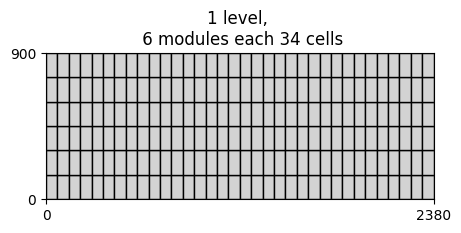

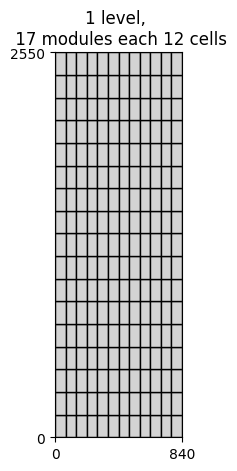

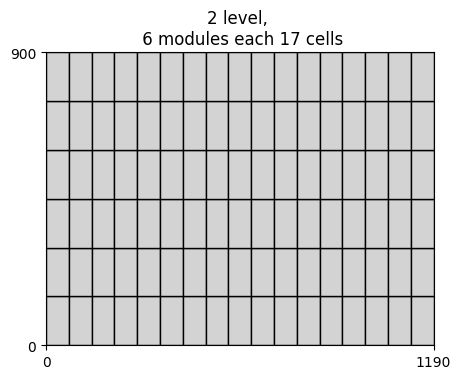

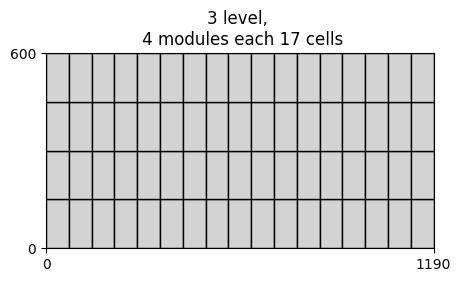

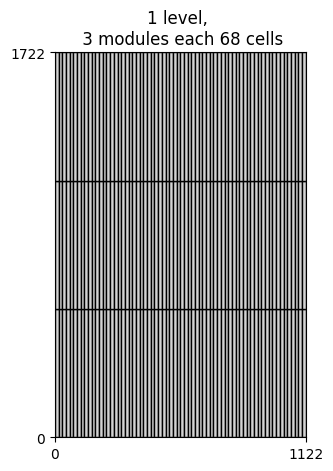

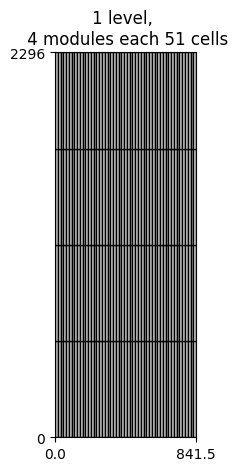

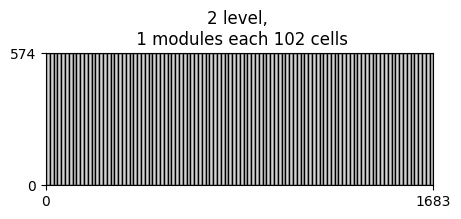

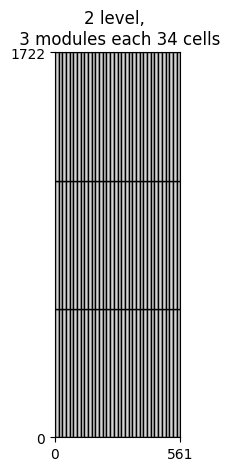

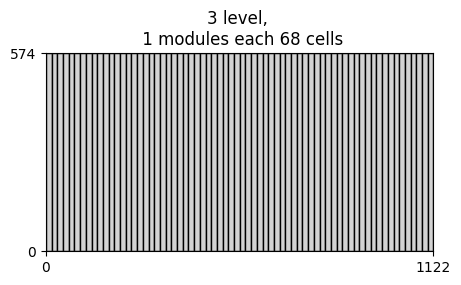

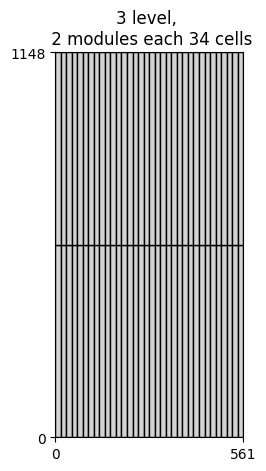

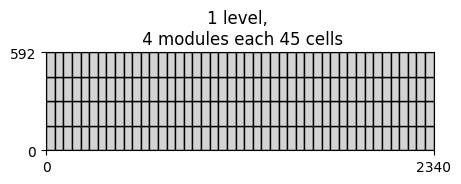

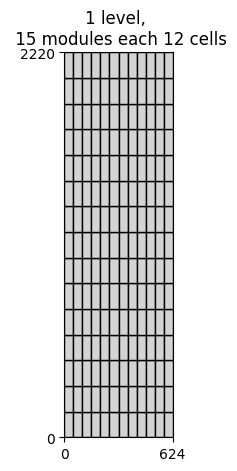

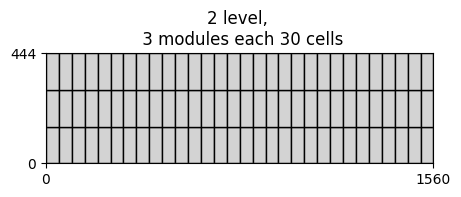

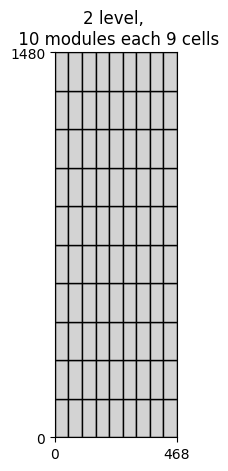

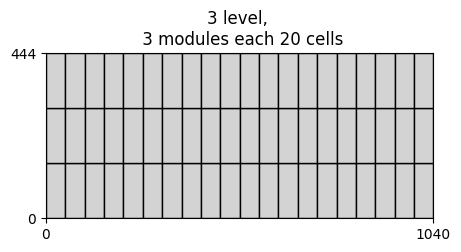

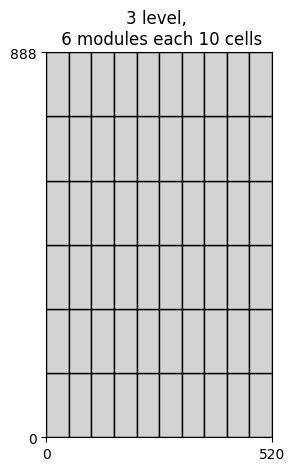

In [731]:
# Printing the schemes

for index, row in cellConfigurationsSolution.loc[cellConfigurationsSolution.index.isin(finalSystemParameters.index)].iterrows():
    # print(index[0])
    # print(row)
    fig, ax = plt.subplots(figsize=(5, 5))
    for i in range(int(row['Transversal cells amount'])):
        for j in range(int(row['Longitudinal cells amount'])):
            ax.add_patch(plt.Rectangle((i * row['Width [mm]'], j * row['Length [mm]']),
                                       row['Width [mm]'], row['Length [mm]'],
                                       edgecolor='black', facecolor='lightgray'))
    ax.set_title(f"{int(index[1])} level, \n {index[2]}")
    ax.set_xlim(0, row['Transversal cells amount'] * row['Width [mm]'])
    ax.set_ylim(0, row['Longitudinal cells amount'] * row['Length [mm]'])

    ax.set_xticks([0, row['Transversal cells amount'] * row['Width [mm]']])
    ax.set_yticks([0, row['Longitudinal cells amount'] * row['Length [mm]']])
    ax.set_aspect("equal")
    ax.grid(True)
    plt.show()